# Comparison of EIF expression depending on mutation in a chosen gene

## Importing dependencies

In [111]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import mannwhitneyu, kruskal
from statsmodels.stats.multitest import fdrcorrection, multipletests
from tqdm import tqdm
from typing import List, Optional

# Defining the data path
DATA_PATH = os.path.join(
    os.pardir, "data", "PanAtlas_2018", "hnsc_tcga_pan_can_atlas_2018"
)
RESULTS_PATH = os.path.join(os.pardir, "results", "mrna_vs_cna")

%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

## Configuration of interesting mRNA and CNA

In [112]:
# Define types of mRNA of interest
mRNAs = ["EIF2S1", "EIF2S2", "EIF2S3"]
#  Choose genes of interest
CNAs = ["TP53", "CDKN2A", "TGFBR2"]

<IPython.core.display.Javascript object>

## Reading raw data

In [113]:
CNA_data_path = os.path.join(DATA_PATH, "data_CNA.txt")
mRNA_data_path = os.path.join(DATA_PATH, "data_RNA_Seq_v2_expression_median.txt")

df_CNA = pd.read_csv(CNA_data_path, sep="\t", index_col=0)
df_CNA = df_CNA.T.iloc[1:, :]

df_mRNA = pd.read_csv(mRNA_data_path, sep="\t", index_col=0)
df_mRNA = df_mRNA.T.iloc[1:, :]
df_mRNA = df_mRNA[mRNAs]
# df_mRNA.reset_index(inplace=True)

<IPython.core.display.Javascript object>

In [114]:
df_CNA.head()

Hugo_Symbol,ACAP3,ACTRT2,AGRN,ANKRD65,ATAD3A,ATAD3B,ATAD3C,AURKAIP1,B3GALT6,C1orf159,...,hsa-mir-1321,hsa-mir-361,hsa-mir-548m,hsa-mir-652,hsa-mir-220a,hsa-mir-513c,hsa-mir-513b,hsa-mir-513a-1,hsa-mir-513a-2,hsa-mir-224
TCGA-4P-AA8J-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-BA-4074-01,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
TCGA-BA-4076-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
TCGA-BA-4078-01,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
TCGA-BA-5149-01,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


<IPython.core.display.Javascript object>

In [115]:
df_mRNA.head()

Hugo_Symbol,EIF2S1,EIF2S2,EIF2S3
TCGA-4P-AA8J-01,1606.53,2018.80,3498.38
TCGA-BA-4074-01,7183.13,3646.10,5204.97
TCGA-BA-4076-01,8621.80,2009.71,4055.62
TCGA-BA-4078-01,1131.14,1690.38,3261.25
TCGA-BA-5149-01,3861.74,2320.67,2701.57


<IPython.core.display.Javascript object>

## Cleaning data

### Removing all mRNAs containing MIR, SNORD and HSA-MIR

In [116]:
no_hsa = [c for c in df_CNA.columns.values if not ("hsa-mir" in str(c).lower())]
df_CNA = df_CNA[no_hsa]
no_snord = [c for c in df_CNA.columns.values if not ("snord" in str(c).lower())]
df_CNA = df_CNA[no_snord]
no_mir = [c for c in df_CNA.columns.values if ("mir" != str(c[:3]).lower())]
df_CNA = df_CNA[no_mir]

# df.dropna(subset=["EIF2S1"], inplace=True)

<IPython.core.display.Javascript object>

## Avoid duplicates; some EIFs appear both in CNA and mRNA datasets

In [117]:
new_names = {}
for mRNA in mRNAs:
    if mRNA in list(df_CNA.columns):
        new_names[mRNA] = mRNA + "_CNA"
df_CNA.rename(columns=new_names, inplace=True)

df = pd.concat([df_mRNA, df_CNA], axis=1)

<IPython.core.display.Javascript object>

In [118]:
df.head()

Hugo_Symbol,EIF2S1,EIF2S2,EIF2S3,ACAP3,ACTRT2,AGRN,ANKRD65,ATAD3A,ATAD3B,ATAD3C,...,RP13-228J13.1,SMIM9,SNORA36A,SNORA56,TMLHE,VBP1,DDX11L16|chrX,IL9R|chrX,SPRY3|chrX,VAMP7|chrX
TCGA-4P-AA8J-01,1606.53,2018.80,3498.38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
TCGA-BA-4074-01,7183.13,3646.10,5204.97,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
TCGA-BA-4076-01,8621.80,2009.71,4055.62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
TCGA-BA-4078-01,1131.14,1690.38,3261.25,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
TCGA-BA-5149-01,3861.74,2320.67,2701.57,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


<IPython.core.display.Javascript object>

# Statistical analysis

### Printing out results for the interesting genes
First screening done only based on p-value of Mann-Whitney U-test

In [119]:
def mrna_cna_mann_whitney_summary(
    df: pd.DataFrame,
    mrna: str,
    cna: str,
    choices: List[str] = ["No change", "Deletion", "Gain"],
    path_to_file: Optional[str] = None,
):
    """
    Function providing a summary of the impact of CNA change on expression of mRNA.
    
    Computes mean mRNA values of possible genetic modifications
    and checks statistical significance of the division based on Mann-Whitney U-test.
    
    Args:
        df (pd.Dataframe): dataframe containing CNA and mRNA data
        mrna (str): name of a chosen mRNA
        cna (str): name of a chosen CNA
        choices (List[str]): list containing three
        path_to_file (Optional[str]): if provided, restuls are written to a file.
            Otherwise, the results are printed in the notebook.
    
    Returns:
    """

    df_tmp = df[[mrna, cna]].copy()
    df_tmp.dropna(inplace=True)

    conditions = [
        df_tmp[cna] == 0,
        (df_tmp[cna] + 1) * (df_tmp[cna] + 2) == 0,
        df_tmp[cna] == 1,
    ]
    new_column = cna + " mutation"
    df_tmp[new_column] = np.select(conditions, choices)

    tissue_kinds = []
    for choice in choices:
        tissue = df_tmp[df_tmp[new_column] == choice][mrna]
        tissue_kinds.append((choice, tissue))
        experiment = f"\nRESULTS FOR {cna}"
        mean_value = f"Mean value of {mrna} for {choice}: {tissue.mean()}"
        if path_to_file:
            with open(path_to_file, "w") as file:
                file.write(experiment)
                file.write(mean_value)
        else:
            print(experiment)
            print(mean_value)

    # Mann-Whitney U-test
    tissue_kinds_pairs = [
        (kind1, kind2)
        for kind1 in tissue_kinds
        for kind2 in tissue_kinds
        if kind1 != kind2
    ]

    for kind1, kind2 in tissue_kinds_pairs:
        result_greater, pvalue_greater = mannwhitneyu(
            kind1[1], kind2[1], alternative="greater"
        )
        result_smaller, pvalue_smaller = mannwhitneyu(
            kind1[1], kind2[1], alternative="less"
        )
        test_type = "Mann - Whitney U-test:"
        greater_results = f"P-value for the 0-hypothesis that {mrna} with {kind1[0]} is not larger than with {kind2[0]}: {pvalue_greater}"
        smaller_results = f"P-value for the 0-hypothesis that {mrna} with {kind1[0]} is not smaller than with {kind2[0]}: {pvalue_smaller}"
        if path_to_file:
            with open(path_to_file, "w") as file:
                file.write(test_type)
                file.write(greater_results)
                file.write(test_type)
                file.write(smaller_results)
        else:
            print(test_type)
            print(greater_results)
            print(test_type)
            print(smaller_results)

    return result_greater, pvalue_greater, result_smaller, pvalue_smaller

<IPython.core.display.Javascript object>

In [120]:
for cna in CNAs:
    for mrna in mRNAs:
        mrna_cna_mann_whitney_summary(df=df, mrna=mrna, cna=cna)


RESULTS FOR TP53
Mean value of EIF2S1 for No change: 2626.0463456790126

RESULTS FOR TP53
Mean value of EIF2S1 for Deletion: 2618.721412698413

RESULTS FOR TP53
Mean value of EIF2S1 for Gain: 3015.2116949152546
Mann - Whitney U-test:
P-value for the 0-hypothesis that EIF2S1 with No change is not larger than with Deletion: 0.412780683139094
Mann - Whitney U-test:
P-value for the 0-hypothesis that EIF2S1 with No change is not smaller than with Deletion: 0.5875336339567274
Mann - Whitney U-test:
P-value for the 0-hypothesis that EIF2S1 with No change is not larger than with Gain: 0.936492612991592
Mann - Whitney U-test:
P-value for the 0-hypothesis that EIF2S1 with No change is not smaller than with Gain: 0.0636667574163414
Mann - Whitney U-test:
P-value for the 0-hypothesis that EIF2S1 with Deletion is not larger than with No change: 0.5875336339567274
Mann - Whitney U-test:
P-value for the 0-hypothesis that EIF2S1 with Deletion is not smaller than with No change: 0.412780683139094
Mann

Mann - Whitney U-test:
P-value for the 0-hypothesis that EIF2S3 with No change is not larger than with Deletion: 0.4607399381278353
Mann - Whitney U-test:
P-value for the 0-hypothesis that EIF2S3 with No change is not smaller than with Deletion: 0.5395694023426938
Mann - Whitney U-test:
P-value for the 0-hypothesis that EIF2S3 with No change is not larger than with Gain: 0.9642670450627099
Mann - Whitney U-test:
P-value for the 0-hypothesis that EIF2S3 with No change is not smaller than with Gain: 0.03593800907713361
Mann - Whitney U-test:
P-value for the 0-hypothesis that EIF2S3 with Deletion is not larger than with No change: 0.5395694023426938
Mann - Whitney U-test:
P-value for the 0-hypothesis that EIF2S3 with Deletion is not smaller than with No change: 0.4607399381278353
Mann - Whitney U-test:
P-value for the 0-hypothesis that EIF2S3 with Deletion is not larger than with Gain: 0.9706649982259224
Mann - Whitney U-test:
P-value for the 0-hypothesis that EIF2S3 with Deletion is not 

<IPython.core.display.Javascript object>

### Saving a complete analysis for all genes

##### This was tried in two scenarios.
##### One sided:
     result, pvalue = mannwhitneyu(normal_tissue, gain_tissue, alternative='less')
##### This tests only one hypothesis that EIF2S1 for normal_tissue is not lower than this with gain/loss.

##### Two sided:
    result, pvalue = mannwhitneyu(normal_tissue, gain_tissue, alternative='two-sided')
###### This tests only one hypothesis that EIF2S1 for normal_tissue is not different with gain/loss.

In [131]:
cols_cna = [col for col in df.columns.values.tolist() if col not in mRNAs]

normal_tissue = {}
gain_tissue = {}
deletion = {}
results = {}
pvalues_gain = {}
pvalues_loss = {}


for mrna in mRNAs:

    print(f"Processing {mrna}")

    filename1 = f"{mrna}_MannWhitney_PanAtlas2018_onesided_noAlteration.txt"
    filename2 = f"{mrna}_MannWhitney_PanAtlas2018_p005_onesided.txt"
    filename3 = f"{mrna}_MannWhitney_PanAtlas2018_p001_onesided.txt"

    path_to_file1 = os.path.join(RESULTS_PATH, filename1)
    path_to_file2 = os.path.join(RESULTS_PATH, filename2)
    path_to_file3 = os.path.join(RESULTS_PATH, filename3)

    file1 = open(path_to_file1, "w")
    file2 = open(path_to_file2, "w")
    file3 = open(path_to_file3, "w")

    normal_tissue[mrna] = {}
    gain_tissue[mrna] = {}
    deletion[mrna] = {}
    pvalues_gain[mrna] = []
    pvalues_loss[mrna] = []
    results[mrna] = []

    for cna in tqdm(cols_cna):

        file1.write("\nRESULTS FOR " + col)

        df_tmp = df[[mrna, cna]].copy()
        df_tmp.dropna(inplace=True)

        conditions = [
            df_tmp[cna] == 0,
            df_tmp[cna] * (df_tmp[cna] - 1) != 0,
            df_tmp[cna] == 1,
        ]
        choices = ["No change", "Deletion", "Gain"]
        new_column = f"{cna}_mutation"
        df_tmp[new_column] = np.select(conditions, choices)

        normal_tissue[mrna][cna] = df_tmp[df_tmp[new_column] == "No change"][mrna]
        gain_tissue[mrna][cna] = df_tmp[df_tmp[new_column] == "Gain"][mrna]
        deletion[mrna][cna] = df_tmp[df_tmp[new_column] == "Deletion"][mrna]

        file1.write(
            f"\nMean value of {mrna} for the normal tissue: {normal_tissue[mrna][cna].mean()}"
        )
        file1.write(
            f"\nMean value of {mrna} for the tissue with gain: {gain_tissue[mrna][cna].mean()}"
        )
        file1.write(
            f"\nMean value of {mrna} for the tissue with deletion: {deletion[mrna][cna].mean()}"
        )

        result, pvalue = mannwhitneyu(
            normal_tissue[mrna][cna], gain_tissue[mrna][cna], alternative="less"
        )
        results[mrna].append((cna, pvalue, "gain"))
        pvalues_gain[mrna].append(pvalue)
        file1.write("\nMann - Whitney U-test:")
        file1.write(
            f"\nP-value for the 0-hypothesis that {mrna} with gain is not larger using the U-test: {pvalue}"
        )
        if pvalue < 0.05:
            file2.write(f"\nResults for: {cna}")
            file2.write("\nMann - Whitney U-test:")
            file2.write(
                f"\nP-value for the 0-hypothesis that {mrna} with gain is not larger using the U-test: {pvalue}"
            )
            if pvalue < 0.01:
                file3.write(f"\nResults for: {cna}")
                file3.write("\nMann - Whitney U-test:")
                file3.write(
                    f"\nP-value for the 0-hypothesis that {mrna} with gain is not larger using the U-test: {pvalue}"
                )

        result, pvalue = mannwhitneyu(
            normal_tissue[mrna][cna], deletion[mrna][cna], alternative="less"
        )
        results[mrna].append((cna, pvalue, "loss"))
        pvalues_loss[mrna].append(pvalue)
        file1.write("\nMann - Whitney U-test:")
        file1.write(
            f"\nP-value for the 0-hypothesis that {mrna} with loss is not larger using the U-test: {pvalue}"
        )
        if pvalue < 0.05:
            file2.write(f"\nResults for: {cna}")
            file2.write("\nMann - Whitney U-test:")
            file2.write(
                f"\nP-value for the 0-hypothesis that {mrna} with loss is not larger using the U-test: {pvalue}"
            )
            if pvalue < 0.01:
                file3.write(f"\nResults for: {cna}")
                file3.write("\nMann - Whitney U-test:")
                file3.write(
                    f"\nP-value for the 0-hypothesis that {mrna} with loss is not larger using the U-test: {pvalue}"
                )

    file1.close()
    file2.close()
    file3.close()



  0%|          | 0/23057 [00:00<?, ?it/s]

  0%|          | 4/23057 [00:00<10:26, 36.80it/s]

Processing EIF2S1




  0%|          | 7/23057 [00:00<11:19, 33.92it/s]

  0%|          | 9/23057 [00:00<14:20, 26.79it/s]

  0%|          | 14/23057 [00:00<12:26, 30.86it/s]

  0%|          | 19/23057 [00:00<12:02, 31.87it/s]

  0%|          | 22/23057 [00:00<14:26, 26.58it/s]

  0%|          | 25/23057 [00:00<14:58, 25.63it/s]

  0%|          | 31/23057 [00:00<12:32, 30.58it/s]

  0%|          | 36/23057 [00:01<11:12, 34.24it/s]

  0%|          | 42/23057 [00:01<09:49, 39.01it/s]

  0%|          | 47/23057 [00:01<09:20, 41.03it/s]

  0%|          | 53/23057 [00:01<08:38, 44.36it/s]

  0%|          | 60/23057 [00:01<07:44, 49.52it/s]

  0%|          | 66/23057 [00:01<07:55, 48.31it/s]

  0%|          | 72/23057 [00:01<08:46, 43.69it/s]

  0%|          | 77/23057 [00:01<09:35, 39.94it/s]

  0%|          | 82/23057 [00:02<09:38, 39.71it/s]

  0%|          | 88/23057 [00:02<08:46, 43.60it/s]

  0%|          | 93/23057 [00:02<08:35, 44.56it/s]

  0%|          | 98/23057 [00:02<08:37, 44.35it/s]

  0%|       

  3%|▎         | 793/23057 [00:17<05:42, 64.95it/s]

  3%|▎         | 801/23057 [00:17<05:35, 66.30it/s]

  4%|▎         | 808/23057 [00:17<05:32, 66.93it/s]

  4%|▎         | 815/23057 [00:17<05:28, 67.74it/s]

  4%|▎         | 822/23057 [00:17<05:27, 67.85it/s]

  4%|▎         | 829/23057 [00:17<05:32, 66.89it/s]

  4%|▎         | 837/23057 [00:18<05:22, 68.95it/s]

  4%|▎         | 844/23057 [00:18<05:47, 63.86it/s]

  4%|▎         | 851/23057 [00:18<05:41, 64.98it/s]

  4%|▎         | 859/23057 [00:18<05:23, 68.70it/s]

  4%|▍         | 867/23057 [00:18<05:18, 69.77it/s]

  4%|▍         | 875/23057 [00:18<05:18, 69.57it/s]

  4%|▍         | 883/23057 [00:18<05:12, 70.85it/s]

  4%|▍         | 891/23057 [00:18<05:19, 69.31it/s]

  4%|▍         | 898/23057 [00:19<06:05, 60.55it/s]

  4%|▍         | 905/23057 [00:19<05:59, 61.54it/s]

  4%|▍         | 912/23057 [00:19<06:18, 58.50it/s]

  4%|▍         | 919/23057 [00:19<06:03, 60.98it/s]

  4%|▍         | 927/23057 [00:19<05:39, 65.10

  8%|▊         | 1736/23057 [00:33<07:07, 49.92it/s]

  8%|▊         | 1743/23057 [00:33<06:31, 54.51it/s]

  8%|▊         | 1751/23057 [00:33<05:57, 59.57it/s]

  8%|▊         | 1758/23057 [00:33<06:27, 55.01it/s]

  8%|▊         | 1766/23057 [00:34<06:07, 57.91it/s]

  8%|▊         | 1773/23057 [00:34<06:01, 58.87it/s]

  8%|▊         | 1780/23057 [00:34<05:45, 61.52it/s]

  8%|▊         | 1787/23057 [00:34<05:47, 61.13it/s]

  8%|▊         | 1795/23057 [00:34<05:26, 65.14it/s]

  8%|▊         | 1803/23057 [00:34<05:15, 67.39it/s]

  8%|▊         | 1810/23057 [00:34<05:27, 64.87it/s]

  8%|▊         | 1817/23057 [00:34<05:54, 59.83it/s]

  8%|▊         | 1824/23057 [00:35<05:52, 60.28it/s]

  8%|▊         | 1831/23057 [00:35<07:06, 49.78it/s]

  8%|▊         | 1837/23057 [00:35<09:11, 38.49it/s]

  8%|▊         | 1842/23057 [00:35<08:59, 39.32it/s]

  8%|▊         | 1849/23057 [00:35<07:56, 44.54it/s]

  8%|▊         | 1857/23057 [00:35<07:03, 50.05it/s]

  8%|▊         | 1863/23057 

 11%|█         | 2531/23057 [00:51<10:38, 32.15it/s]

 11%|█         | 2535/23057 [00:51<10:55, 31.31it/s]

 11%|█         | 2539/23057 [00:51<10:44, 31.84it/s]

 11%|█         | 2543/23057 [00:51<10:19, 33.10it/s]

 11%|█         | 2547/23057 [00:51<10:30, 32.55it/s]

 11%|█         | 2551/23057 [00:51<12:01, 28.43it/s]

 11%|█         | 2556/23057 [00:51<10:53, 31.38it/s]

 11%|█         | 2560/23057 [00:52<11:11, 30.54it/s]

 11%|█         | 2565/23057 [00:52<10:14, 33.35it/s]

 11%|█         | 2569/23057 [00:52<09:48, 34.82it/s]

 11%|█         | 2574/23057 [00:52<09:10, 37.22it/s]

 11%|█         | 2578/23057 [00:52<09:25, 36.24it/s]

 11%|█         | 2583/23057 [00:52<08:47, 38.80it/s]

 11%|█         | 2588/23057 [00:52<09:43, 35.06it/s]

 11%|█         | 2592/23057 [00:52<09:31, 35.82it/s]

 11%|█▏        | 2596/23057 [00:53<09:40, 35.28it/s]

 11%|█▏        | 2600/23057 [00:53<09:22, 36.39it/s]

 11%|█▏        | 2604/23057 [00:53<09:19, 36.58it/s]

 11%|█▏        | 2609/23057 

 14%|█▍        | 3320/23057 [01:07<05:09, 63.81it/s]

 14%|█▍        | 3327/23057 [01:07<05:03, 65.00it/s]

 14%|█▍        | 3335/23057 [01:07<04:51, 67.70it/s]

 14%|█▍        | 3342/23057 [01:07<04:58, 66.09it/s]

 15%|█▍        | 3349/23057 [01:07<05:01, 65.46it/s]

 15%|█▍        | 3356/23057 [01:08<04:58, 65.97it/s]

 15%|█▍        | 3364/23057 [01:08<04:49, 67.95it/s]

 15%|█▍        | 3372/23057 [01:08<04:41, 69.85it/s]

 15%|█▍        | 3380/23057 [01:08<04:39, 70.46it/s]

 15%|█▍        | 3388/23057 [01:08<04:37, 70.91it/s]

 15%|█▍        | 3396/23057 [01:08<04:36, 71.07it/s]

 15%|█▍        | 3404/23057 [01:08<04:46, 68.58it/s]

 15%|█▍        | 3411/23057 [01:08<04:47, 68.36it/s]

 15%|█▍        | 3418/23057 [01:08<05:11, 63.08it/s]

 15%|█▍        | 3426/23057 [01:09<04:58, 65.74it/s]

 15%|█▍        | 3433/23057 [01:09<05:00, 65.41it/s]

 15%|█▍        | 3440/23057 [01:09<05:22, 60.90it/s]

 15%|█▍        | 3448/23057 [01:09<05:04, 64.48it/s]

 15%|█▍        | 3456/23057 

 18%|█▊        | 4265/23057 [01:22<04:58, 63.01it/s]

 19%|█▊        | 4272/23057 [01:23<04:57, 63.17it/s]

 19%|█▊        | 4280/23057 [01:23<04:46, 65.44it/s]

 19%|█▊        | 4287/23057 [01:23<04:42, 66.44it/s]

 19%|█▊        | 4295/23057 [01:23<04:40, 66.79it/s]

 19%|█▊        | 4303/23057 [01:23<04:33, 68.69it/s]

 19%|█▊        | 4310/23057 [01:23<04:33, 68.63it/s]

 19%|█▊        | 4318/23057 [01:23<04:29, 69.57it/s]

 19%|█▉        | 4325/23057 [01:23<04:38, 67.17it/s]

 19%|█▉        | 4332/23057 [01:23<04:58, 62.63it/s]

 19%|█▉        | 4339/23057 [01:24<04:51, 64.14it/s]

 19%|█▉        | 4346/23057 [01:24<05:00, 62.34it/s]

 19%|█▉        | 4353/23057 [01:24<05:22, 58.03it/s]

 19%|█▉        | 4359/23057 [01:24<05:30, 56.65it/s]

 19%|█▉        | 4365/23057 [01:24<05:52, 52.96it/s]

 19%|█▉        | 4371/23057 [01:24<06:23, 48.72it/s]

 19%|█▉        | 4377/23057 [01:24<06:33, 47.44it/s]

 19%|█▉        | 4382/23057 [01:25<07:36, 40.93it/s]

 19%|█▉        | 4387/23057 

 23%|██▎       | 5201/23057 [01:39<04:40, 63.72it/s]

 23%|██▎       | 5208/23057 [01:39<05:10, 57.56it/s]

 23%|██▎       | 5214/23057 [01:39<05:09, 57.64it/s]

 23%|██▎       | 5222/23057 [01:39<04:49, 61.57it/s]

 23%|██▎       | 5230/23057 [01:39<04:32, 65.39it/s]

 23%|██▎       | 5238/23057 [01:39<04:23, 67.73it/s]

 23%|██▎       | 5245/23057 [01:39<04:41, 63.32it/s]

 23%|██▎       | 5252/23057 [01:39<04:59, 59.53it/s]

 23%|██▎       | 5259/23057 [01:40<04:58, 59.55it/s]

 23%|██▎       | 5266/23057 [01:40<05:10, 57.25it/s]

 23%|██▎       | 5272/23057 [01:40<05:08, 57.73it/s]

 23%|██▎       | 5278/23057 [01:40<05:23, 54.94it/s]

 23%|██▎       | 5284/23057 [01:40<05:37, 52.59it/s]

 23%|██▎       | 5290/23057 [01:40<05:25, 54.56it/s]

 23%|██▎       | 5297/23057 [01:40<05:09, 57.43it/s]

 23%|██▎       | 5304/23057 [01:40<04:57, 59.76it/s]

 23%|██▎       | 5311/23057 [01:40<05:11, 56.97it/s]

 23%|██▎       | 5319/23057 [01:41<04:51, 60.84it/s]

 23%|██▎       | 5326/23057 

 27%|██▋       | 6164/23057 [01:54<05:11, 54.30it/s]

 27%|██▋       | 6170/23057 [01:54<05:28, 51.33it/s]

 27%|██▋       | 6176/23057 [01:54<05:21, 52.46it/s]

 27%|██▋       | 6182/23057 [01:54<05:20, 52.69it/s]

 27%|██▋       | 6188/23057 [01:55<05:58, 47.01it/s]

 27%|██▋       | 6195/23057 [01:55<05:26, 51.64it/s]

 27%|██▋       | 6202/23057 [01:55<05:06, 54.95it/s]

 27%|██▋       | 6209/23057 [01:55<04:51, 57.84it/s]

 27%|██▋       | 6215/23057 [01:55<04:50, 57.95it/s]

 27%|██▋       | 6222/23057 [01:55<04:40, 59.93it/s]

 27%|██▋       | 6230/23057 [01:55<04:25, 63.32it/s]

 27%|██▋       | 6237/23057 [01:55<04:27, 62.78it/s]

 27%|██▋       | 6245/23057 [01:55<04:17, 65.31it/s]

 27%|██▋       | 6252/23057 [01:56<04:36, 60.79it/s]

 27%|██▋       | 6260/23057 [01:56<04:26, 62.97it/s]

 27%|██▋       | 6268/23057 [01:56<04:14, 66.01it/s]

 27%|██▋       | 6275/23057 [01:56<04:19, 64.63it/s]

 27%|██▋       | 6282/23057 [01:56<04:13, 66.06it/s]

 27%|██▋       | 6289/23057 

 31%|███       | 7123/23057 [02:10<05:16, 50.38it/s]

 31%|███       | 7129/23057 [02:10<05:26, 48.80it/s]

 31%|███       | 7135/23057 [02:10<05:11, 51.04it/s]

 31%|███       | 7141/23057 [02:10<05:09, 51.44it/s]

 31%|███       | 7147/23057 [02:10<05:08, 51.62it/s]

 31%|███       | 7154/23057 [02:10<04:46, 55.53it/s]

 31%|███       | 7160/23057 [02:10<04:42, 56.24it/s]

 31%|███       | 7166/23057 [02:10<04:47, 55.28it/s]

 31%|███       | 7173/23057 [02:11<04:32, 58.21it/s]

 31%|███       | 7180/23057 [02:11<04:20, 60.85it/s]

 31%|███       | 7188/23057 [02:11<04:07, 64.20it/s]

 31%|███       | 7195/23057 [02:11<04:07, 64.09it/s]

 31%|███       | 7202/23057 [02:11<04:25, 59.73it/s]

 31%|███▏      | 7210/23057 [02:11<04:10, 63.14it/s]

 31%|███▏      | 7217/23057 [02:11<04:03, 64.92it/s]

 31%|███▏      | 7225/23057 [02:11<03:52, 68.09it/s]

 31%|███▏      | 7232/23057 [02:11<04:14, 62.12it/s]

 31%|███▏      | 7240/23057 [02:12<04:02, 65.25it/s]

 31%|███▏      | 7248/23057 

 35%|███▌      | 8077/23057 [02:25<04:16, 58.31it/s]

 35%|███▌      | 8083/23057 [02:25<04:19, 57.74it/s]

 35%|███▌      | 8090/23057 [02:25<04:06, 60.71it/s]

 35%|███▌      | 8098/23057 [02:25<03:49, 65.16it/s]

 35%|███▌      | 8105/23057 [02:25<04:30, 55.36it/s]

 35%|███▌      | 8112/23057 [02:26<04:18, 57.82it/s]

 35%|███▌      | 8119/23057 [02:26<04:58, 50.02it/s]

 35%|███▌      | 8125/23057 [02:26<04:54, 50.76it/s]

 35%|███▌      | 8131/23057 [02:26<04:58, 50.03it/s]

 35%|███▌      | 8138/23057 [02:26<04:33, 54.56it/s]

 35%|███▌      | 8145/23057 [02:26<04:16, 58.24it/s]

 35%|███▌      | 8152/23057 [02:26<04:07, 60.14it/s]

 35%|███▌      | 8159/23057 [02:26<04:41, 52.89it/s]

 35%|███▌      | 8165/23057 [02:27<04:59, 49.65it/s]

 35%|███▌      | 8172/23057 [02:27<04:36, 53.84it/s]

 35%|███▌      | 8179/23057 [02:27<04:17, 57.84it/s]

 36%|███▌      | 8186/23057 [02:27<04:11, 59.07it/s]

 36%|███▌      | 8194/23057 [02:27<03:55, 63.06it/s]

 36%|███▌      | 8201/23057 

 39%|███▉      | 9029/23057 [02:41<03:44, 62.36it/s]

 39%|███▉      | 9036/23057 [02:41<03:51, 60.48it/s]

 39%|███▉      | 9044/23057 [02:41<03:40, 63.53it/s]

 39%|███▉      | 9052/23057 [02:41<03:31, 66.06it/s]

 39%|███▉      | 9060/23057 [02:41<03:26, 67.85it/s]

 39%|███▉      | 9067/23057 [02:41<03:42, 62.92it/s]

 39%|███▉      | 9074/23057 [02:42<03:35, 64.76it/s]

 39%|███▉      | 9081/23057 [02:42<03:32, 65.86it/s]

 39%|███▉      | 9089/23057 [02:42<03:25, 67.83it/s]

 39%|███▉      | 9097/23057 [02:42<03:21, 69.25it/s]

 39%|███▉      | 9104/23057 [02:42<03:27, 67.39it/s]

 40%|███▉      | 9111/23057 [02:42<03:26, 67.46it/s]

 40%|███▉      | 9119/23057 [02:42<03:22, 68.85it/s]

 40%|███▉      | 9127/23057 [02:42<03:18, 70.04it/s]

 40%|███▉      | 9135/23057 [02:42<03:43, 62.33it/s]

 40%|███▉      | 9142/23057 [02:43<03:36, 64.14it/s]

 40%|███▉      | 9149/23057 [02:43<03:32, 65.43it/s]

 40%|███▉      | 9157/23057 [02:43<03:29, 66.37it/s]

 40%|███▉      | 9164/23057 

 43%|████▎     | 9978/23057 [02:56<03:38, 59.87it/s]

 43%|████▎     | 9985/23057 [02:57<03:31, 61.82it/s]

 43%|████▎     | 9993/23057 [02:57<03:21, 64.77it/s]

 43%|████▎     | 10001/23057 [02:57<03:14, 67.13it/s]

 43%|████▎     | 10009/23057 [02:57<03:07, 69.55it/s]

 43%|████▎     | 10017/23057 [02:57<03:05, 70.25it/s]

 43%|████▎     | 10025/23057 [02:57<03:09, 68.61it/s]

 44%|████▎     | 10033/23057 [02:57<03:05, 70.30it/s]

 44%|████▎     | 10041/23057 [02:57<03:03, 70.89it/s]

 44%|████▎     | 10049/23057 [02:57<03:16, 66.36it/s]

 44%|████▎     | 10057/23057 [02:58<03:10, 68.25it/s]

 44%|████▎     | 10065/23057 [02:58<03:05, 69.98it/s]

 44%|████▎     | 10073/23057 [02:58<03:09, 68.47it/s]

 44%|████▎     | 10081/23057 [02:58<03:04, 70.45it/s]

 44%|████▍     | 10089/23057 [02:58<03:01, 71.63it/s]

 44%|████▍     | 10097/23057 [02:58<03:03, 70.64it/s]

 44%|████▍     | 10105/23057 [02:58<03:02, 71.10it/s]

 44%|████▍     | 10113/23057 [02:58<02:57, 72.84it/s]

 44%|████▍   

 47%|████▋     | 10920/23057 [03:12<03:14, 62.42it/s]

 47%|████▋     | 10927/23057 [03:12<03:10, 63.66it/s]

 47%|████▋     | 10934/23057 [03:12<03:08, 64.40it/s]

 47%|████▋     | 10941/23057 [03:12<03:19, 60.66it/s]

 47%|████▋     | 10949/23057 [03:12<03:09, 63.97it/s]

 48%|████▊     | 10957/23057 [03:12<03:01, 66.69it/s]

 48%|████▊     | 10965/23057 [03:13<02:56, 68.56it/s]

 48%|████▊     | 10973/23057 [03:13<02:52, 70.17it/s]

 48%|████▊     | 10981/23057 [03:13<02:49, 71.14it/s]

 48%|████▊     | 10989/23057 [03:13<02:47, 72.07it/s]

 48%|████▊     | 10997/23057 [03:13<02:45, 72.86it/s]

 48%|████▊     | 11005/23057 [03:13<02:50, 70.84it/s]

 48%|████▊     | 11013/23057 [03:13<02:48, 71.53it/s]

 48%|████▊     | 11021/23057 [03:13<02:50, 70.71it/s]

 48%|████▊     | 11029/23057 [03:13<02:52, 69.56it/s]

 48%|████▊     | 11036/23057 [03:14<03:13, 62.22it/s]

 48%|████▊     | 11043/23057 [03:14<03:22, 59.26it/s]

 48%|████▊     | 11051/23057 [03:14<03:08, 63.55it/s]

 48%|████▊

 51%|█████▏    | 11867/23057 [03:27<02:54, 64.10it/s]

 51%|█████▏    | 11874/23057 [03:27<02:50, 65.51it/s]

 52%|█████▏    | 11882/23057 [03:27<02:44, 68.13it/s]

 52%|█████▏    | 11889/23057 [03:27<02:52, 64.72it/s]

 52%|█████▏    | 11896/23057 [03:28<02:49, 65.82it/s]

 52%|█████▏    | 11903/23057 [03:28<02:48, 66.30it/s]

 52%|█████▏    | 11910/23057 [03:28<02:45, 67.21it/s]

 52%|█████▏    | 11917/23057 [03:28<02:44, 67.73it/s]

 52%|█████▏    | 11925/23057 [03:28<02:41, 69.06it/s]

 52%|█████▏    | 11933/23057 [03:28<02:42, 68.53it/s]

 52%|█████▏    | 11940/23057 [03:28<03:00, 61.75it/s]

 52%|█████▏    | 11947/23057 [03:28<03:00, 61.61it/s]

 52%|█████▏    | 11954/23057 [03:28<02:59, 61.80it/s]

 52%|█████▏    | 11961/23057 [03:29<02:53, 63.82it/s]

 52%|█████▏    | 11968/23057 [03:29<02:54, 63.51it/s]

 52%|█████▏    | 11975/23057 [03:29<03:11, 57.84it/s]

 52%|█████▏    | 11983/23057 [03:29<02:59, 61.69it/s]

 52%|█████▏    | 11991/23057 [03:29<02:48, 65.60it/s]

 52%|█████

 56%|█████▌    | 12806/23057 [03:43<03:40, 46.49it/s]

 56%|█████▌    | 12812/23057 [03:43<03:25, 49.75it/s]

 56%|█████▌    | 12820/23057 [03:43<03:05, 55.05it/s]

 56%|█████▌    | 12828/23057 [03:43<02:50, 60.02it/s]

 56%|█████▌    | 12836/23057 [03:43<02:40, 63.56it/s]

 56%|█████▌    | 12844/23057 [03:43<02:34, 66.11it/s]

 56%|█████▌    | 12852/23057 [03:43<02:28, 68.64it/s]

 56%|█████▌    | 12860/23057 [03:43<02:35, 65.76it/s]

 56%|█████▌    | 12868/23057 [03:44<02:33, 66.40it/s]

 56%|█████▌    | 12875/23057 [03:44<02:41, 63.02it/s]

 56%|█████▌    | 12882/23057 [03:44<02:36, 64.82it/s]

 56%|█████▌    | 12890/23057 [03:44<02:31, 67.22it/s]

 56%|█████▌    | 12898/23057 [03:44<02:27, 68.94it/s]

 56%|█████▌    | 12906/23057 [03:44<02:26, 69.52it/s]

 56%|█████▌    | 12914/23057 [03:44<02:33, 66.06it/s]

 56%|█████▌    | 12921/23057 [03:44<02:47, 60.47it/s]

 56%|█████▌    | 12928/23057 [03:45<02:54, 58.11it/s]

 56%|█████▌    | 12934/23057 [03:45<02:57, 57.05it/s]

 56%|█████

 60%|█████▉    | 13759/23057 [03:58<02:27, 63.13it/s]

 60%|█████▉    | 13766/23057 [03:58<02:27, 62.98it/s]

 60%|█████▉    | 13774/23057 [03:58<02:21, 65.52it/s]

 60%|█████▉    | 13782/23057 [03:58<02:16, 68.12it/s]

 60%|█████▉    | 13789/23057 [03:58<02:16, 67.79it/s]

 60%|█████▉    | 13797/23057 [03:58<02:14, 68.96it/s]

 60%|█████▉    | 13805/23057 [03:58<02:10, 70.73it/s]

 60%|█████▉    | 13813/23057 [03:58<02:20, 65.99it/s]

 60%|█████▉    | 13820/23057 [03:59<02:23, 64.56it/s]

 60%|█████▉    | 13827/23057 [03:59<02:32, 60.41it/s]

 60%|█████▉    | 13834/23057 [03:59<02:35, 59.43it/s]

 60%|██████    | 13841/23057 [03:59<02:33, 60.08it/s]

 60%|██████    | 13849/23057 [03:59<02:25, 63.40it/s]

 60%|██████    | 13857/23057 [03:59<02:18, 66.28it/s]

 60%|██████    | 13864/23057 [03:59<02:26, 62.75it/s]

 60%|██████    | 13871/23057 [03:59<02:46, 55.19it/s]

 60%|██████    | 13877/23057 [04:00<02:48, 54.55it/s]

 60%|██████    | 13883/23057 [04:00<02:53, 52.83it/s]

 60%|█████

 64%|██████▍   | 14716/23057 [04:13<02:05, 66.44it/s]

 64%|██████▍   | 14723/23057 [04:13<02:04, 67.12it/s]

 64%|██████▍   | 14731/23057 [04:13<02:00, 69.06it/s]

 64%|██████▍   | 14739/23057 [04:13<01:59, 69.80it/s]

 64%|██████▍   | 14747/23057 [04:13<02:03, 67.46it/s]

 64%|██████▍   | 14755/23057 [04:14<01:58, 69.79it/s]

 64%|██████▍   | 14763/23057 [04:14<01:58, 69.72it/s]

 64%|██████▍   | 14771/23057 [04:14<02:01, 68.04it/s]

 64%|██████▍   | 14779/23057 [04:14<01:58, 69.99it/s]

 64%|██████▍   | 14787/23057 [04:14<01:56, 70.72it/s]

 64%|██████▍   | 14795/23057 [04:14<01:59, 69.37it/s]

 64%|██████▍   | 14802/23057 [04:14<01:59, 69.11it/s]

 64%|██████▍   | 14809/23057 [04:14<02:09, 63.88it/s]

 64%|██████▍   | 14816/23057 [04:14<02:21, 58.40it/s]

 64%|██████▍   | 14822/23057 [04:15<02:22, 57.98it/s]

 64%|██████▍   | 14828/23057 [04:15<02:26, 56.32it/s]

 64%|██████▍   | 14834/23057 [04:15<02:27, 55.79it/s]

 64%|██████▍   | 14841/23057 [04:15<02:25, 56.40it/s]

 64%|█████

 68%|██████▊   | 15654/23057 [04:28<02:14, 54.88it/s]

 68%|██████▊   | 15660/23057 [04:28<02:31, 48.85it/s]

 68%|██████▊   | 15668/23057 [04:29<02:16, 54.11it/s]

 68%|██████▊   | 15674/23057 [04:29<02:28, 49.87it/s]

 68%|██████▊   | 15680/23057 [04:29<02:34, 47.69it/s]

 68%|██████▊   | 15687/23057 [04:29<02:20, 52.44it/s]

 68%|██████▊   | 15695/23057 [04:29<02:08, 57.39it/s]

 68%|██████▊   | 15702/23057 [04:29<02:01, 60.40it/s]

 68%|██████▊   | 15709/23057 [04:29<02:05, 58.58it/s]

 68%|██████▊   | 15716/23057 [04:29<02:16, 53.79it/s]

 68%|██████▊   | 15723/23057 [04:30<02:08, 57.12it/s]

 68%|██████▊   | 15729/23057 [04:30<02:12, 55.51it/s]

 68%|██████▊   | 15735/23057 [04:30<02:15, 54.14it/s]

 68%|██████▊   | 15741/23057 [04:30<02:31, 48.35it/s]

 68%|██████▊   | 15748/23057 [04:30<02:19, 52.26it/s]

 68%|██████▊   | 15755/23057 [04:30<02:11, 55.60it/s]

 68%|██████▊   | 15763/23057 [04:30<02:01, 59.91it/s]

 68%|██████▊   | 15770/23057 [04:30<01:58, 61.73it/s]

 68%|█████

 72%|███████▏  | 16606/23057 [04:44<01:43, 62.24it/s]

 72%|███████▏  | 16613/23057 [04:44<01:43, 62.16it/s]

 72%|███████▏  | 16620/23057 [04:44<01:42, 62.68it/s]

 72%|███████▏  | 16627/23057 [04:44<01:39, 64.47it/s]

 72%|███████▏  | 16634/23057 [04:44<01:37, 65.95it/s]

 72%|███████▏  | 16641/23057 [04:44<01:35, 66.95it/s]

 72%|███████▏  | 16648/23057 [04:44<01:34, 67.74it/s]

 72%|███████▏  | 16655/23057 [04:44<01:36, 66.03it/s]

 72%|███████▏  | 16662/23057 [04:44<01:54, 55.63it/s]

 72%|███████▏  | 16669/23057 [04:45<01:50, 57.66it/s]

 72%|███████▏  | 16675/23057 [04:45<01:51, 57.35it/s]

 72%|███████▏  | 16681/23057 [04:45<01:52, 56.67it/s]

 72%|███████▏  | 16687/23057 [04:45<01:53, 56.13it/s]

 72%|███████▏  | 16693/23057 [04:45<01:55, 54.91it/s]

 72%|███████▏  | 16699/23057 [04:45<01:53, 56.16it/s]

 72%|███████▏  | 16706/23057 [04:45<01:47, 58.84it/s]

 72%|███████▏  | 16713/23057 [04:45<01:44, 60.48it/s]

 73%|███████▎  | 16720/23057 [04:45<01:50, 57.21it/s]

 73%|█████

 76%|███████▌  | 17539/23057 [04:59<01:36, 57.04it/s]

 76%|███████▌  | 17547/23057 [04:59<01:30, 60.91it/s]

 76%|███████▌  | 17555/23057 [04:59<01:27, 63.14it/s]

 76%|███████▌  | 17562/23057 [04:59<01:32, 59.17it/s]

 76%|███████▌  | 17569/23057 [04:59<01:40, 54.72it/s]

 76%|███████▌  | 17575/23057 [05:00<01:45, 51.81it/s]

 76%|███████▋  | 17581/23057 [05:00<01:59, 45.64it/s]

 76%|███████▋  | 17586/23057 [05:00<02:16, 40.11it/s]

 76%|███████▋  | 17591/23057 [05:00<02:21, 38.69it/s]

 76%|███████▋  | 17596/23057 [05:00<02:19, 39.11it/s]

 76%|███████▋  | 17601/23057 [05:00<02:27, 37.11it/s]

 76%|███████▋  | 17606/23057 [05:00<02:16, 39.93it/s]

 76%|███████▋  | 17613/23057 [05:01<02:00, 45.25it/s]

 76%|███████▋  | 17620/23057 [05:01<01:50, 49.31it/s]

 76%|███████▋  | 17628/23057 [05:01<01:39, 54.33it/s]

 76%|███████▋  | 17635/23057 [05:01<01:34, 57.59it/s]

 77%|███████▋  | 17642/23057 [05:01<01:29, 60.24it/s]

 77%|███████▋  | 17649/23057 [05:01<01:27, 61.88it/s]

 77%|█████

 80%|████████  | 18460/23057 [05:15<01:23, 54.88it/s]

 80%|████████  | 18466/23057 [05:15<01:22, 55.71it/s]

 80%|████████  | 18473/23057 [05:15<01:17, 58.88it/s]

 80%|████████  | 18480/23057 [05:15<01:14, 61.10it/s]

 80%|████████  | 18488/23057 [05:15<01:10, 64.56it/s]

 80%|████████  | 18495/23057 [05:15<01:16, 59.56it/s]

 80%|████████  | 18503/23057 [05:16<01:12, 63.22it/s]

 80%|████████  | 18510/23057 [05:16<01:15, 60.23it/s]

 80%|████████  | 18518/23057 [05:16<01:11, 63.24it/s]

 80%|████████  | 18525/23057 [05:16<01:10, 64.13it/s]

 80%|████████  | 18532/23057 [05:16<01:10, 64.59it/s]

 80%|████████  | 18539/23057 [05:16<01:11, 63.22it/s]

 80%|████████  | 18546/23057 [05:16<01:11, 63.01it/s]

 80%|████████  | 18553/23057 [05:16<01:11, 63.34it/s]

 80%|████████  | 18560/23057 [05:16<01:11, 63.27it/s]

 81%|████████  | 18567/23057 [05:17<01:14, 60.58it/s]

 81%|████████  | 18574/23057 [05:17<01:12, 62.12it/s]

 81%|████████  | 18581/23057 [05:17<01:11, 62.57it/s]

 81%|█████

 84%|████████▎ | 19296/23057 [05:31<01:54, 32.71it/s]

 84%|████████▎ | 19301/23057 [05:31<01:43, 36.27it/s]

 84%|████████▎ | 19307/23057 [05:31<01:32, 40.35it/s]

 84%|████████▍ | 19312/23057 [05:31<01:27, 42.58it/s]

 84%|████████▍ | 19317/23057 [05:31<01:26, 43.31it/s]

 84%|████████▍ | 19322/23057 [05:31<01:49, 34.05it/s]

 84%|████████▍ | 19326/23057 [05:32<02:26, 25.42it/s]

 84%|████████▍ | 19330/23057 [05:32<03:15, 19.10it/s]

 84%|████████▍ | 19333/23057 [05:32<04:05, 15.20it/s]

 84%|████████▍ | 19336/23057 [05:32<03:59, 15.54it/s]

 84%|████████▍ | 19338/23057 [05:33<03:55, 15.81it/s]

 84%|████████▍ | 19341/23057 [05:33<03:34, 17.30it/s]

 84%|████████▍ | 19345/23057 [05:33<02:59, 20.69it/s]

 84%|████████▍ | 19350/23057 [05:33<02:29, 24.72it/s]

 84%|████████▍ | 19355/23057 [05:33<02:07, 29.02it/s]

 84%|████████▍ | 19359/23057 [05:33<02:18, 26.78it/s]

 84%|████████▍ | 19363/23057 [05:33<02:55, 21.03it/s]

 84%|████████▍ | 19366/23057 [05:34<02:50, 21.68it/s]

 84%|█████

 87%|████████▋ | 20063/23057 [05:47<00:57, 51.87it/s]

 87%|████████▋ | 20069/23057 [05:48<00:57, 51.64it/s]

 87%|████████▋ | 20076/23057 [05:48<00:53, 55.26it/s]

 87%|████████▋ | 20083/23057 [05:48<00:50, 58.60it/s]

 87%|████████▋ | 20091/23057 [05:48<00:47, 62.25it/s]

 87%|████████▋ | 20098/23057 [05:48<00:45, 64.36it/s]

 87%|████████▋ | 20106/23057 [05:48<00:43, 67.47it/s]

 87%|████████▋ | 20113/23057 [05:48<00:43, 67.64it/s]

 87%|████████▋ | 20120/23057 [05:48<00:44, 66.64it/s]

 87%|████████▋ | 20127/23057 [05:48<00:44, 66.26it/s]

 87%|████████▋ | 20135/23057 [05:49<00:43, 67.81it/s]

 87%|████████▋ | 20142/23057 [05:49<00:47, 60.77it/s]

 87%|████████▋ | 20149/23057 [05:49<00:47, 60.91it/s]

 87%|████████▋ | 20157/23057 [05:49<00:45, 64.17it/s]

 87%|████████▋ | 20165/23057 [05:49<00:43, 66.87it/s]

 87%|████████▋ | 20172/23057 [05:49<00:42, 67.29it/s]

 88%|████████▊ | 20179/23057 [05:49<00:48, 58.74it/s]

 88%|████████▊ | 20186/23057 [05:49<00:54, 52.73it/s]

 88%|█████

 91%|█████████ | 20975/23057 [06:03<00:33, 62.15it/s]

 91%|█████████ | 20982/23057 [06:04<00:40, 51.53it/s]

 91%|█████████ | 20988/23057 [06:04<00:49, 41.83it/s]

 91%|█████████ | 20993/23057 [06:04<00:48, 42.71it/s]

 91%|█████████ | 21000/23057 [06:04<00:43, 47.20it/s]

 91%|█████████ | 21006/23057 [06:04<00:44, 45.63it/s]

 91%|█████████ | 21011/23057 [06:04<00:47, 43.49it/s]

 91%|█████████ | 21016/23057 [06:05<01:03, 32.32it/s]

 91%|█████████ | 21022/23057 [06:05<00:54, 37.02it/s]

 91%|█████████ | 21027/23057 [06:05<00:53, 38.24it/s]

 91%|█████████ | 21034/23057 [06:05<00:47, 43.03it/s]

 91%|█████████ | 21039/23057 [06:05<00:46, 43.03it/s]

 91%|█████████▏| 21044/23057 [06:05<00:51, 38.91it/s]

 91%|█████████▏| 21051/23057 [06:05<00:45, 44.54it/s]

 91%|█████████▏| 21057/23057 [06:05<00:41, 47.76it/s]

 91%|█████████▏| 21063/23057 [06:05<00:42, 47.33it/s]

 91%|█████████▏| 21070/23057 [06:06<00:38, 52.28it/s]

 91%|█████████▏| 21076/23057 [06:06<00:37, 52.52it/s]

 91%|█████

 95%|█████████▍| 21794/23057 [06:20<00:25, 49.72it/s]

 95%|█████████▍| 21801/23057 [06:20<00:23, 53.64it/s]

 95%|█████████▍| 21807/23057 [06:20<00:23, 52.89it/s]

 95%|█████████▍| 21814/23057 [06:21<00:22, 55.75it/s]

 95%|█████████▍| 21820/23057 [06:21<00:22, 55.13it/s]

 95%|█████████▍| 21827/23057 [06:21<00:21, 57.65it/s]

 95%|█████████▍| 21834/23057 [06:21<00:20, 60.66it/s]

 95%|█████████▍| 21842/23057 [06:21<00:18, 64.26it/s]

 95%|█████████▍| 21850/23057 [06:21<00:18, 66.51it/s]

 95%|█████████▍| 21857/23057 [06:21<00:20, 59.47it/s]

 95%|█████████▍| 21865/23057 [06:21<00:18, 62.95it/s]

 95%|█████████▍| 21873/23057 [06:21<00:17, 66.24it/s]

 95%|█████████▍| 21881/23057 [06:22<00:17, 68.49it/s]

 95%|█████████▍| 21889/23057 [06:22<00:16, 70.47it/s]

 95%|█████████▍| 21897/23057 [06:22<00:16, 70.87it/s]

 95%|█████████▌| 21905/23057 [06:22<00:15, 72.02it/s]

 95%|█████████▌| 21913/23057 [06:22<00:16, 67.56it/s]

 95%|█████████▌| 21920/23057 [06:22<00:18, 62.26it/s]

 95%|█████

 99%|█████████▊| 22714/23057 [06:36<00:05, 59.58it/s]

 99%|█████████▊| 22721/23057 [06:36<00:05, 61.28it/s]

 99%|█████████▊| 22728/23057 [06:36<00:05, 56.76it/s]

 99%|█████████▊| 22734/23057 [06:36<00:05, 57.23it/s]

 99%|█████████▊| 22740/23057 [06:37<00:09, 34.81it/s]

 99%|█████████▊| 22745/23057 [06:37<00:08, 36.30it/s]

 99%|█████████▊| 22750/23057 [06:37<00:08, 36.02it/s]

 99%|█████████▊| 22755/23057 [06:37<00:08, 37.74it/s]

 99%|█████████▊| 22760/23057 [06:37<00:08, 34.01it/s]

 99%|█████████▊| 22764/23057 [06:37<00:08, 33.07it/s]

 99%|█████████▊| 22768/23057 [06:37<00:11, 25.80it/s]

 99%|█████████▉| 22774/23057 [06:38<00:09, 29.75it/s]

 99%|█████████▉| 22780/23057 [06:38<00:08, 34.38it/s]

 99%|█████████▉| 22785/23057 [06:38<00:07, 35.36it/s]

 99%|█████████▉| 22791/23057 [06:38<00:06, 39.99it/s]

 99%|█████████▉| 22799/23057 [06:38<00:05, 45.96it/s]

 99%|█████████▉| 22806/23057 [06:38<00:05, 49.75it/s]

 99%|█████████▉| 22812/23057 [06:38<00:05, 48.86it/s]

 99%|█████

Processing EIF2S2




  0%|          | 11/23057 [00:00<08:13, 46.67it/s]

  0%|          | 16/23057 [00:00<08:06, 47.34it/s]

  0%|          | 21/23057 [00:00<09:21, 41.05it/s]

  0%|          | 25/23057 [00:00<09:41, 39.63it/s]

  0%|          | 29/23057 [00:00<12:16, 31.26it/s]

  0%|          | 32/23057 [00:00<13:18, 28.83it/s]

  0%|          | 37/23057 [00:01<11:55, 32.17it/s]

  0%|          | 41/23057 [00:01<14:11, 27.02it/s]

  0%|          | 44/23057 [00:01<14:26, 26.55it/s]

  0%|          | 48/23057 [00:01<13:23, 28.64it/s]

  0%|          | 52/23057 [00:01<13:16, 28.89it/s]

  0%|          | 55/23057 [00:01<15:39, 24.47it/s]

  0%|          | 59/23057 [00:01<14:27, 26.52it/s]

  0%|          | 63/23057 [00:02<13:24, 28.59it/s]

  0%|          | 67/23057 [00:02<12:55, 29.64it/s]

  0%|          | 71/23057 [00:02<13:32, 28.30it/s]

  0%|          | 76/23057 [00:02<11:46, 32.52it/s]

  0%|          | 81/23057 [00:02<10:42, 35.76it/s]

  0%|          | 86/23057 [00:02<09:55, 38.61it/s]

  0%|     

  4%|▍         | 910/23057 [00:16<07:11, 51.37it/s]

  4%|▍         | 916/23057 [00:17<07:00, 52.61it/s]

  4%|▍         | 922/23057 [00:17<07:45, 47.59it/s]

  4%|▍         | 927/23057 [00:17<10:46, 34.24it/s]

  4%|▍         | 932/23057 [00:17<10:12, 36.13it/s]

  4%|▍         | 939/23057 [00:17<08:45, 42.07it/s]

  4%|▍         | 947/23057 [00:17<07:37, 48.31it/s]

  4%|▍         | 953/23057 [00:17<07:19, 50.30it/s]

  4%|▍         | 959/23057 [00:17<07:07, 51.65it/s]

  4%|▍         | 965/23057 [00:18<07:22, 49.89it/s]

  4%|▍         | 971/23057 [00:18<07:35, 48.46it/s]

  4%|▍         | 977/23057 [00:18<07:59, 46.03it/s]

  4%|▍         | 984/23057 [00:18<07:16, 50.55it/s]

  4%|▍         | 990/23057 [00:18<07:01, 52.35it/s]

  4%|▍         | 996/23057 [00:18<06:51, 53.58it/s]

  4%|▍         | 1003/23057 [00:18<06:29, 56.56it/s]

  4%|▍         | 1009/23057 [00:18<06:32, 56.17it/s]

  4%|▍         | 1015/23057 [00:19<06:25, 57.18it/s]

  4%|▍         | 1021/23057 [00:19<06:24, 5

  8%|▊         | 1762/23057 [00:33<07:24, 47.94it/s]

  8%|▊         | 1767/23057 [00:33<07:23, 47.99it/s]

  8%|▊         | 1773/23057 [00:33<07:03, 50.25it/s]

  8%|▊         | 1779/23057 [00:33<06:59, 50.74it/s]

  8%|▊         | 1785/23057 [00:33<07:11, 49.25it/s]

  8%|▊         | 1790/23057 [00:33<07:19, 48.34it/s]

  8%|▊         | 1795/23057 [00:34<07:16, 48.72it/s]

  8%|▊         | 1801/23057 [00:34<07:03, 50.25it/s]

  8%|▊         | 1807/23057 [00:34<07:29, 47.29it/s]

  8%|▊         | 1812/23057 [00:34<07:27, 47.49it/s]

  8%|▊         | 1818/23057 [00:34<07:07, 49.69it/s]

  8%|▊         | 1824/23057 [00:34<06:58, 50.77it/s]

  8%|▊         | 1830/23057 [00:34<06:58, 50.67it/s]

  8%|▊         | 1837/23057 [00:34<06:27, 54.71it/s]

  8%|▊         | 1843/23057 [00:34<07:01, 50.36it/s]

  8%|▊         | 1850/23057 [00:35<06:28, 54.54it/s]

  8%|▊         | 1857/23057 [00:35<06:05, 58.06it/s]

  8%|▊         | 1864/23057 [00:35<11:57, 29.54it/s]

  8%|▊         | 1870/23057 

 11%|█         | 2572/23057 [00:50<06:33, 52.11it/s]

 11%|█         | 2578/23057 [00:50<06:39, 51.30it/s]

 11%|█         | 2584/23057 [00:50<06:29, 52.63it/s]

 11%|█         | 2590/23057 [00:51<07:55, 43.06it/s]

 11%|█▏        | 2595/23057 [00:51<07:46, 43.91it/s]

 11%|█▏        | 2602/23057 [00:51<07:31, 45.31it/s]

 11%|█▏        | 2607/23057 [00:51<07:23, 46.07it/s]

 11%|█▏        | 2614/23057 [00:51<06:45, 50.43it/s]

 11%|█▏        | 2620/23057 [00:51<07:55, 43.00it/s]

 11%|█▏        | 2625/23057 [00:51<09:23, 36.23it/s]

 11%|█▏        | 2630/23057 [00:52<10:10, 33.46it/s]

 11%|█▏        | 2634/23057 [00:52<12:06, 28.11it/s]

 11%|█▏        | 2638/23057 [00:52<12:16, 27.72it/s]

 11%|█▏        | 2642/23057 [00:52<11:32, 29.46it/s]

 11%|█▏        | 2646/23057 [00:52<12:42, 26.77it/s]

 11%|█▏        | 2650/23057 [00:52<11:46, 28.88it/s]

 12%|█▏        | 2654/23057 [00:52<12:02, 28.23it/s]

 12%|█▏        | 2658/23057 [00:53<11:41, 29.09it/s]

 12%|█▏        | 2662/23057 

 14%|█▍        | 3321/23057 [01:08<07:29, 43.86it/s]

 14%|█▍        | 3329/23057 [01:08<06:31, 50.41it/s]

 14%|█▍        | 3336/23057 [01:08<06:00, 54.70it/s]

 14%|█▍        | 3343/23057 [01:09<05:40, 57.93it/s]

 15%|█▍        | 3350/23057 [01:09<05:42, 57.55it/s]

 15%|█▍        | 3357/23057 [01:09<06:22, 51.57it/s]

 15%|█▍        | 3363/23057 [01:09<06:56, 47.25it/s]

 15%|█▍        | 3370/23057 [01:09<06:22, 51.49it/s]

 15%|█▍        | 3378/23057 [01:09<05:52, 55.82it/s]

 15%|█▍        | 3385/23057 [01:09<05:41, 57.55it/s]

 15%|█▍        | 3391/23057 [01:09<05:51, 55.89it/s]

 15%|█▍        | 3398/23057 [01:10<05:40, 57.72it/s]

 15%|█▍        | 3406/23057 [01:10<05:21, 61.15it/s]

 15%|█▍        | 3413/23057 [01:10<05:57, 54.98it/s]

 15%|█▍        | 3419/23057 [01:10<05:58, 54.76it/s]

 15%|█▍        | 3425/23057 [01:10<05:51, 55.80it/s]

 15%|█▍        | 3431/23057 [01:10<05:57, 54.96it/s]

 15%|█▍        | 3437/23057 [01:10<06:37, 49.41it/s]

 15%|█▍        | 3443/23057 

 18%|█▊        | 4204/23057 [01:25<05:36, 55.98it/s]

 18%|█▊        | 4211/23057 [01:25<05:31, 56.88it/s]

 18%|█▊        | 4218/23057 [01:25<05:20, 58.84it/s]

 18%|█▊        | 4225/23057 [01:25<05:11, 60.47it/s]

 18%|█▊        | 4232/23057 [01:25<05:12, 60.30it/s]

 18%|█▊        | 4239/23057 [01:25<05:23, 58.16it/s]

 18%|█▊        | 4245/23057 [01:25<05:23, 58.13it/s]

 18%|█▊        | 4251/23057 [01:26<08:58, 34.95it/s]

 18%|█▊        | 4256/23057 [01:26<08:13, 38.06it/s]

 18%|█▊        | 4262/23057 [01:26<07:22, 42.46it/s]

 19%|█▊        | 4268/23057 [01:26<07:37, 41.04it/s]

 19%|█▊        | 4273/23057 [01:26<07:32, 41.49it/s]

 19%|█▊        | 4278/23057 [01:26<08:07, 38.49it/s]

 19%|█▊        | 4283/23057 [01:26<07:45, 40.32it/s]

 19%|█▊        | 4289/23057 [01:26<06:59, 44.71it/s]

 19%|█▊        | 4296/23057 [01:27<06:21, 49.18it/s]

 19%|█▊        | 4302/23057 [01:27<06:00, 51.99it/s]

 19%|█▊        | 4308/23057 [01:27<06:35, 47.39it/s]

 19%|█▊        | 4314/23057 

 22%|██▏       | 4966/23057 [01:41<05:58, 50.42it/s]

 22%|██▏       | 4973/23057 [01:42<05:41, 52.92it/s]

 22%|██▏       | 4979/23057 [01:42<05:33, 54.15it/s]

 22%|██▏       | 4985/23057 [01:42<05:59, 50.28it/s]

 22%|██▏       | 4991/23057 [01:42<05:52, 51.21it/s]

 22%|██▏       | 4997/23057 [01:42<06:22, 47.20it/s]

 22%|██▏       | 5003/23057 [01:42<06:02, 49.76it/s]

 22%|██▏       | 5010/23057 [01:42<05:35, 53.73it/s]

 22%|██▏       | 5017/23057 [01:42<05:22, 55.94it/s]

 22%|██▏       | 5025/23057 [01:43<04:57, 60.68it/s]

 22%|██▏       | 5033/23057 [01:43<04:42, 63.75it/s]

 22%|██▏       | 5040/23057 [01:43<04:48, 62.45it/s]

 22%|██▏       | 5047/23057 [01:43<05:44, 52.34it/s]

 22%|██▏       | 5053/23057 [01:43<06:18, 47.59it/s]

 22%|██▏       | 5061/23057 [01:43<05:38, 53.09it/s]

 22%|██▏       | 5068/23057 [01:43<05:19, 56.23it/s]

 22%|██▏       | 5075/23057 [01:43<05:13, 57.45it/s]

 22%|██▏       | 5082/23057 [01:44<05:05, 58.91it/s]

 22%|██▏       | 5090/23057 

 26%|██▌       | 5881/23057 [01:57<05:12, 54.96it/s]

 26%|██▌       | 5887/23057 [01:58<05:06, 56.10it/s]

 26%|██▌       | 5895/23057 [01:58<04:44, 60.32it/s]

 26%|██▌       | 5902/23057 [01:58<04:44, 60.27it/s]

 26%|██▌       | 5909/23057 [01:58<04:34, 62.54it/s]

 26%|██▌       | 5916/23057 [01:58<04:30, 63.28it/s]

 26%|██▌       | 5923/23057 [01:58<04:35, 62.17it/s]

 26%|██▌       | 5930/23057 [01:58<04:36, 61.95it/s]

 26%|██▌       | 5938/23057 [01:58<04:25, 64.43it/s]

 26%|██▌       | 5945/23057 [01:58<04:28, 63.66it/s]

 26%|██▌       | 5952/23057 [01:59<04:24, 64.65it/s]

 26%|██▌       | 5959/23057 [01:59<04:22, 65.23it/s]

 26%|██▌       | 5966/23057 [01:59<04:47, 59.40it/s]

 26%|██▌       | 5973/23057 [01:59<04:37, 61.53it/s]

 26%|██▌       | 5980/23057 [01:59<04:34, 62.23it/s]

 26%|██▌       | 5987/23057 [01:59<04:39, 61.17it/s]

 26%|██▌       | 5994/23057 [01:59<04:31, 62.93it/s]

 26%|██▌       | 6001/23057 [01:59<04:25, 64.17it/s]

 26%|██▌       | 6008/23057 

 30%|██▉       | 6805/23057 [02:13<03:54, 69.39it/s]

 30%|██▉       | 6813/23057 [02:13<03:52, 69.76it/s]

 30%|██▉       | 6821/23057 [02:14<03:49, 70.65it/s]

 30%|██▉       | 6829/23057 [02:14<03:52, 69.94it/s]

 30%|██▉       | 6837/23057 [02:14<04:08, 65.32it/s]

 30%|██▉       | 6844/23057 [02:14<04:04, 66.30it/s]

 30%|██▉       | 6852/23057 [02:14<03:57, 68.31it/s]

 30%|██▉       | 6859/23057 [02:14<04:03, 66.45it/s]

 30%|██▉       | 6866/23057 [02:14<04:11, 64.30it/s]

 30%|██▉       | 6874/23057 [02:14<03:59, 67.66it/s]

 30%|██▉       | 6882/23057 [02:14<03:52, 69.51it/s]

 30%|██▉       | 6890/23057 [02:15<03:48, 70.89it/s]

 30%|██▉       | 6898/23057 [02:15<03:46, 71.28it/s]

 30%|██▉       | 6906/23057 [02:15<04:06, 65.53it/s]

 30%|██▉       | 6914/23057 [02:15<03:57, 67.84it/s]

 30%|███       | 6921/23057 [02:15<04:10, 64.53it/s]

 30%|███       | 6928/23057 [02:15<04:28, 60.18it/s]

 30%|███       | 6935/23057 [02:15<04:32, 59.20it/s]

 30%|███       | 6942/23057 

 34%|███▎      | 7749/23057 [02:29<03:52, 65.73it/s]

 34%|███▎      | 7756/23057 [02:29<04:04, 62.68it/s]

 34%|███▎      | 7763/23057 [02:29<04:00, 63.72it/s]

 34%|███▎      | 7770/23057 [02:29<03:59, 63.88it/s]

 34%|███▎      | 7778/23057 [02:29<03:49, 66.59it/s]

 34%|███▍      | 7785/23057 [02:30<03:46, 67.32it/s]

 34%|███▍      | 7793/23057 [02:30<03:41, 68.80it/s]

 34%|███▍      | 7801/23057 [02:30<03:35, 70.68it/s]

 34%|███▍      | 7809/23057 [02:30<03:42, 68.46it/s]

 34%|███▍      | 7816/23057 [02:30<04:15, 59.60it/s]

 34%|███▍      | 7823/23057 [02:30<04:43, 53.82it/s]

 34%|███▍      | 7829/23057 [02:30<04:42, 53.93it/s]

 34%|███▍      | 7836/23057 [02:30<04:30, 56.21it/s]

 34%|███▍      | 7844/23057 [02:30<04:10, 60.80it/s]

 34%|███▍      | 7851/23057 [02:31<04:42, 53.92it/s]

 34%|███▍      | 7857/23057 [02:31<05:06, 49.62it/s]

 34%|███▍      | 7864/23057 [02:31<04:42, 53.80it/s]

 34%|███▍      | 7870/23057 [02:31<04:58, 50.83it/s]

 34%|███▍      | 7876/23057 

 38%|███▊      | 8665/23057 [02:45<03:59, 60.12it/s]

 38%|███▊      | 8672/23057 [02:45<03:50, 62.36it/s]

 38%|███▊      | 8679/23057 [02:45<03:58, 60.22it/s]

 38%|███▊      | 8686/23057 [02:45<04:18, 55.70it/s]

 38%|███▊      | 8692/23057 [02:45<04:20, 55.04it/s]

 38%|███▊      | 8698/23057 [02:45<04:19, 55.34it/s]

 38%|███▊      | 8704/23057 [02:46<04:14, 56.46it/s]

 38%|███▊      | 8710/23057 [02:46<04:23, 54.45it/s]

 38%|███▊      | 8716/23057 [02:46<04:21, 54.85it/s]

 38%|███▊      | 8722/23057 [02:46<05:12, 45.94it/s]

 38%|███▊      | 8729/23057 [02:46<04:41, 50.90it/s]

 38%|███▊      | 8737/23057 [02:46<04:17, 55.64it/s]

 38%|███▊      | 8743/23057 [02:46<04:16, 55.88it/s]

 38%|███▊      | 8750/23057 [02:46<04:05, 58.22it/s]

 38%|███▊      | 8757/23057 [02:46<03:56, 60.47it/s]

 38%|███▊      | 8765/23057 [02:47<03:41, 64.42it/s]

 38%|███▊      | 8772/23057 [02:47<03:39, 65.04it/s]

 38%|███▊      | 8779/23057 [02:47<03:55, 60.61it/s]

 38%|███▊      | 8786/23057 

 42%|████▏     | 9607/23057 [03:01<04:00, 55.97it/s]

 42%|████▏     | 9613/23057 [03:01<04:26, 50.51it/s]

 42%|████▏     | 9619/23057 [03:01<04:35, 48.70it/s]

 42%|████▏     | 9626/23057 [03:01<04:15, 52.54it/s]

 42%|████▏     | 9633/23057 [03:01<04:00, 55.78it/s]

 42%|████▏     | 9640/23057 [03:01<03:50, 58.11it/s]

 42%|████▏     | 9648/23057 [03:01<03:35, 62.36it/s]

 42%|████▏     | 9655/23057 [03:01<03:28, 64.26it/s]

 42%|████▏     | 9663/23057 [03:02<03:22, 66.08it/s]

 42%|████▏     | 9671/23057 [03:02<03:20, 66.76it/s]

 42%|████▏     | 9678/23057 [03:02<03:41, 60.47it/s]

 42%|████▏     | 9685/23057 [03:02<03:35, 61.97it/s]

 42%|████▏     | 9693/23057 [03:02<03:22, 65.93it/s]

 42%|████▏     | 9701/23057 [03:02<03:12, 69.24it/s]

 42%|████▏     | 9709/23057 [03:02<03:07, 71.10it/s]

 42%|████▏     | 9717/23057 [03:02<03:10, 70.17it/s]

 42%|████▏     | 9725/23057 [03:02<03:20, 66.43it/s]

 42%|████▏     | 9732/23057 [03:03<03:20, 66.60it/s]

 42%|████▏     | 9740/23057 

 46%|████▌     | 10543/23057 [03:17<03:46, 55.29it/s]

 46%|████▌     | 10549/23057 [03:17<04:09, 50.19it/s]

 46%|████▌     | 10556/23057 [03:17<03:55, 53.15it/s]

 46%|████▌     | 10564/23057 [03:17<03:40, 56.68it/s]

 46%|████▌     | 10570/23057 [03:18<03:40, 56.69it/s]

 46%|████▌     | 10577/23057 [03:18<03:28, 59.93it/s]

 46%|████▌     | 10584/23057 [03:18<03:24, 61.04it/s]

 46%|████▌     | 10591/23057 [03:18<03:19, 62.42it/s]

 46%|████▌     | 10599/23057 [03:18<03:10, 65.29it/s]

 46%|████▌     | 10606/23057 [03:18<03:07, 66.40it/s]

 46%|████▌     | 10614/23057 [03:18<02:58, 69.87it/s]

 46%|████▌     | 10622/23057 [03:18<03:01, 68.67it/s]

 46%|████▌     | 10629/23057 [03:18<03:04, 67.48it/s]

 46%|████▌     | 10636/23057 [03:19<03:28, 59.47it/s]

 46%|████▌     | 10643/23057 [03:19<03:27, 59.91it/s]

 46%|████▌     | 10650/23057 [03:19<03:27, 59.82it/s]

 46%|████▌     | 10658/23057 [03:19<03:18, 62.55it/s]

 46%|████▋     | 10666/23057 [03:19<03:08, 65.76it/s]

 46%|████▋

 50%|████▉     | 11468/23057 [03:33<02:55, 65.98it/s]

 50%|████▉     | 11476/23057 [03:33<02:49, 68.17it/s]

 50%|████▉     | 11483/23057 [03:33<03:01, 63.87it/s]

 50%|████▉     | 11491/23057 [03:33<02:53, 66.78it/s]

 50%|████▉     | 11498/23057 [03:33<02:53, 66.82it/s]

 50%|████▉     | 11506/23057 [03:33<02:47, 69.14it/s]

 50%|████▉     | 11514/23057 [03:33<02:43, 70.75it/s]

 50%|████▉     | 11522/23057 [03:33<02:43, 70.41it/s]

 50%|█████     | 11530/23057 [03:34<02:42, 71.14it/s]

 50%|█████     | 11538/23057 [03:34<02:44, 69.82it/s]

 50%|█████     | 11546/23057 [03:34<02:40, 71.87it/s]

 50%|█████     | 11554/23057 [03:34<02:43, 70.41it/s]

 50%|█████     | 11562/23057 [03:34<02:42, 70.93it/s]

 50%|█████     | 11570/23057 [03:34<02:48, 67.98it/s]

 50%|█████     | 11577/23057 [03:34<02:50, 67.45it/s]

 50%|█████     | 11584/23057 [03:34<02:58, 64.25it/s]

 50%|█████     | 11591/23057 [03:35<02:56, 65.01it/s]

 50%|█████     | 11598/23057 [03:35<03:09, 60.38it/s]

 50%|█████

 53%|█████▎    | 12280/23057 [03:50<06:31, 27.56it/s]

 53%|█████▎    | 12284/23057 [03:50<06:15, 28.72it/s]

 53%|█████▎    | 12288/23057 [03:50<06:06, 29.35it/s]

 53%|█████▎    | 12294/23057 [03:51<05:13, 34.35it/s]

 53%|█████▎    | 12298/23057 [03:51<08:34, 20.91it/s]

 53%|█████▎    | 12303/23057 [03:51<07:09, 25.05it/s]

 53%|█████▎    | 12309/23057 [03:51<05:58, 29.99it/s]

 53%|█████▎    | 12314/23057 [03:51<05:15, 34.00it/s]

 53%|█████▎    | 12319/23057 [03:51<06:38, 26.97it/s]

 53%|█████▎    | 12323/23057 [03:52<07:13, 24.75it/s]

 53%|█████▎    | 12327/23057 [03:52<08:36, 20.79it/s]

 53%|█████▎    | 12330/23057 [03:52<08:53, 20.11it/s]

 53%|█████▎    | 12333/23057 [03:52<08:05, 22.09it/s]

 54%|█████▎    | 12337/23057 [03:52<08:22, 21.32it/s]

 54%|█████▎    | 12340/23057 [03:53<09:59, 17.87it/s]

 54%|█████▎    | 12343/23057 [03:53<08:49, 20.23it/s]

 54%|█████▎    | 12346/23057 [03:53<08:41, 20.55it/s]

 54%|█████▎    | 12352/23057 [03:53<07:02, 25.31it/s]

 54%|█████

 56%|█████▌    | 12946/23057 [04:08<04:46, 35.25it/s]

 56%|█████▌    | 12952/23057 [04:08<04:16, 39.38it/s]

 56%|█████▌    | 12959/23057 [04:08<03:51, 43.56it/s]

 56%|█████▌    | 12965/23057 [04:08<03:38, 46.11it/s]

 56%|█████▋    | 12970/23057 [04:08<03:41, 45.55it/s]

 56%|█████▋    | 12976/23057 [04:08<03:30, 47.94it/s]

 56%|█████▋    | 12981/23057 [04:08<03:31, 47.60it/s]

 56%|█████▋    | 12986/23057 [04:08<03:46, 44.49it/s]

 56%|█████▋    | 12991/23057 [04:09<03:58, 42.17it/s]

 56%|█████▋    | 12998/23057 [04:09<03:32, 47.44it/s]

 56%|█████▋    | 13005/23057 [04:09<03:17, 50.97it/s]

 56%|█████▋    | 13012/23057 [04:09<03:08, 53.34it/s]

 56%|█████▋    | 13019/23057 [04:09<02:57, 56.61it/s]

 56%|█████▋    | 13026/23057 [04:09<02:48, 59.58it/s]

 57%|█████▋    | 13033/23057 [04:09<03:17, 50.87it/s]

 57%|█████▋    | 13039/23057 [04:09<03:57, 42.25it/s]

 57%|█████▋    | 13046/23057 [04:10<03:32, 47.16it/s]

 57%|█████▋    | 13053/23057 [04:10<03:12, 51.98it/s]

 57%|█████

 60%|█████▉    | 13832/23057 [04:24<02:18, 66.50it/s]

 60%|██████    | 13840/23057 [04:24<02:14, 68.36it/s]

 60%|██████    | 13847/23057 [04:24<02:20, 65.34it/s]

 60%|██████    | 13854/23057 [04:24<02:25, 63.13it/s]

 60%|██████    | 13862/23057 [04:24<02:19, 65.83it/s]

 60%|██████    | 13870/23057 [04:24<02:16, 67.31it/s]

 60%|██████    | 13877/23057 [04:25<02:24, 63.66it/s]

 60%|██████    | 13885/23057 [04:25<02:18, 66.03it/s]

 60%|██████    | 13893/23057 [04:25<02:14, 68.01it/s]

 60%|██████    | 13901/23057 [04:25<02:11, 69.59it/s]

 60%|██████    | 13909/23057 [04:25<02:16, 67.22it/s]

 60%|██████    | 13916/23057 [04:25<02:18, 65.85it/s]

 60%|██████    | 13923/23057 [04:25<02:24, 63.23it/s]

 60%|██████    | 13930/23057 [04:25<02:27, 62.04it/s]

 60%|██████    | 13937/23057 [04:25<02:42, 56.02it/s]

 60%|██████    | 13943/23057 [04:26<02:47, 54.27it/s]

 60%|██████    | 13949/23057 [04:26<02:51, 52.99it/s]

 61%|██████    | 13955/23057 [04:26<02:52, 52.79it/s]

 61%|█████

 64%|██████▍   | 14745/23057 [04:39<02:01, 68.46it/s]

 64%|██████▍   | 14752/23057 [04:39<02:01, 68.50it/s]

 64%|██████▍   | 14760/23057 [04:40<01:57, 70.73it/s]

 64%|██████▍   | 14768/23057 [04:40<01:57, 70.34it/s]

 64%|██████▍   | 14776/23057 [04:40<01:59, 69.18it/s]

 64%|██████▍   | 14783/23057 [04:40<02:00, 68.93it/s]

 64%|██████▍   | 14790/23057 [04:40<02:11, 63.08it/s]

 64%|██████▍   | 14797/23057 [04:40<02:32, 54.20it/s]

 64%|██████▍   | 14803/23057 [04:40<02:29, 55.19it/s]

 64%|██████▍   | 14809/23057 [04:40<02:55, 46.95it/s]

 64%|██████▍   | 14815/23057 [04:41<03:00, 45.68it/s]

 64%|██████▍   | 14821/23057 [04:41<02:51, 47.95it/s]

 64%|██████▍   | 14827/23057 [04:41<02:45, 49.81it/s]

 64%|██████▍   | 14833/23057 [04:41<02:39, 51.46it/s]

 64%|██████▍   | 14840/23057 [04:41<02:31, 54.23it/s]

 64%|██████▍   | 14847/23057 [04:41<02:23, 57.23it/s]

 64%|██████▍   | 14854/23057 [04:41<02:17, 59.76it/s]

 64%|██████▍   | 14861/23057 [04:41<02:13, 61.56it/s]

 64%|█████

 68%|██████▊   | 15653/23057 [04:55<03:06, 39.62it/s]

 68%|██████▊   | 15658/23057 [04:55<03:11, 38.68it/s]

 68%|██████▊   | 15662/23057 [04:56<03:10, 38.90it/s]

 68%|██████▊   | 15667/23057 [04:56<02:57, 41.65it/s]

 68%|██████▊   | 15673/23057 [04:56<02:54, 42.40it/s]

 68%|██████▊   | 15678/23057 [04:56<02:56, 41.80it/s]

 68%|██████▊   | 15684/23057 [04:56<02:43, 45.04it/s]

 68%|██████▊   | 15691/23057 [04:56<02:28, 49.44it/s]

 68%|██████▊   | 15698/23057 [04:56<02:20, 52.42it/s]

 68%|██████▊   | 15705/23057 [04:56<02:12, 55.46it/s]

 68%|██████▊   | 15712/23057 [04:56<02:05, 58.55it/s]

 68%|██████▊   | 15719/23057 [04:57<02:03, 59.54it/s]

 68%|██████▊   | 15726/23057 [04:57<01:58, 62.12it/s]

 68%|██████▊   | 15733/23057 [04:57<02:00, 60.91it/s]

 68%|██████▊   | 15740/23057 [04:57<01:57, 62.13it/s]

 68%|██████▊   | 15748/23057 [04:57<01:51, 65.56it/s]

 68%|██████▊   | 15756/23057 [04:57<01:47, 67.73it/s]

 68%|██████▊   | 15763/23057 [04:57<01:46, 68.30it/s]

 68%|█████

 72%|███████▏  | 16577/23057 [05:11<02:06, 51.11it/s]

 72%|███████▏  | 16583/23057 [05:11<02:08, 50.47it/s]

 72%|███████▏  | 16589/23057 [05:11<02:12, 48.78it/s]

 72%|███████▏  | 16596/23057 [05:11<02:03, 52.26it/s]

 72%|███████▏  | 16604/23057 [05:11<01:53, 57.09it/s]

 72%|███████▏  | 16612/23057 [05:11<01:46, 60.76it/s]

 72%|███████▏  | 16620/23057 [05:11<01:40, 64.23it/s]

 72%|███████▏  | 16627/23057 [05:11<01:38, 65.54it/s]

 72%|███████▏  | 16634/23057 [05:12<01:40, 64.21it/s]

 72%|███████▏  | 16641/23057 [05:12<01:37, 65.80it/s]

 72%|███████▏  | 16649/23057 [05:12<01:34, 68.04it/s]

 72%|███████▏  | 16656/23057 [05:12<01:42, 62.50it/s]

 72%|███████▏  | 16663/23057 [05:12<01:39, 64.15it/s]

 72%|███████▏  | 16670/23057 [05:12<01:39, 64.26it/s]

 72%|███████▏  | 16677/23057 [05:12<01:38, 64.79it/s]

 72%|███████▏  | 16685/23057 [05:12<01:33, 68.32it/s]

 72%|███████▏  | 16693/23057 [05:12<01:30, 70.50it/s]

 72%|███████▏  | 16701/23057 [05:13<01:31, 69.56it/s]

 72%|█████

 76%|███████▌  | 17526/23057 [05:26<01:44, 52.83it/s]

 76%|███████▌  | 17532/23057 [05:26<01:51, 49.57it/s]

 76%|███████▌  | 17539/23057 [05:26<01:45, 52.15it/s]

 76%|███████▌  | 17545/23057 [05:26<01:42, 53.57it/s]

 76%|███████▌  | 17551/23057 [05:26<01:47, 51.44it/s]

 76%|███████▌  | 17557/23057 [05:26<01:44, 52.70it/s]

 76%|███████▌  | 17564/23057 [05:27<01:37, 56.36it/s]

 76%|███████▌  | 17571/23057 [05:27<01:33, 58.87it/s]

 76%|███████▌  | 17578/23057 [05:27<01:29, 61.23it/s]

 76%|███████▋  | 17585/23057 [05:27<01:36, 56.64it/s]

 76%|███████▋  | 17592/23057 [05:27<01:31, 59.68it/s]

 76%|███████▋  | 17599/23057 [05:27<01:29, 60.90it/s]

 76%|███████▋  | 17606/23057 [05:27<01:26, 63.25it/s]

 76%|███████▋  | 17613/23057 [05:27<01:24, 64.53it/s]

 76%|███████▋  | 17620/23057 [05:27<01:28, 61.44it/s]

 76%|███████▋  | 17628/23057 [05:28<01:23, 65.12it/s]

 76%|███████▋  | 17636/23057 [05:28<01:20, 67.74it/s]

 77%|███████▋  | 17643/23057 [05:28<01:19, 68.02it/s]

 77%|█████

 80%|████████  | 18476/23057 [05:41<01:28, 52.02it/s]

 80%|████████  | 18482/23057 [05:41<01:25, 53.36it/s]

 80%|████████  | 18489/23057 [05:41<01:20, 56.67it/s]

 80%|████████  | 18497/23057 [05:41<01:14, 60.88it/s]

 80%|████████  | 18504/23057 [05:41<01:13, 62.34it/s]

 80%|████████  | 18511/23057 [05:42<01:29, 50.89it/s]

 80%|████████  | 18517/23057 [05:42<01:46, 42.82it/s]

 80%|████████  | 18524/23057 [05:42<01:36, 47.19it/s]

 80%|████████  | 18531/23057 [05:42<01:27, 51.46it/s]

 80%|████████  | 18537/23057 [05:42<01:26, 52.55it/s]

 80%|████████  | 18545/23057 [05:42<01:19, 56.97it/s]

 80%|████████  | 18553/23057 [05:42<01:13, 61.05it/s]

 81%|████████  | 18561/23057 [05:43<01:09, 64.40it/s]

 81%|████████  | 18569/23057 [05:43<01:07, 66.50it/s]

 81%|████████  | 18576/23057 [05:43<01:10, 63.25it/s]

 81%|████████  | 18583/23057 [05:43<01:20, 55.36it/s]

 81%|████████  | 18589/23057 [05:43<01:23, 53.20it/s]

 81%|████████  | 18596/23057 [05:43<01:19, 56.36it/s]

 81%|█████

 84%|████████▍ | 19416/23057 [05:57<01:06, 55.08it/s]

 84%|████████▍ | 19423/23057 [05:57<01:02, 58.25it/s]

 84%|████████▍ | 19429/23057 [05:57<01:03, 57.39it/s]

 84%|████████▍ | 19437/23057 [05:57<01:00, 60.24it/s]

 84%|████████▍ | 19445/23057 [05:57<00:56, 63.81it/s]

 84%|████████▍ | 19452/23057 [05:57<00:57, 62.39it/s]

 84%|████████▍ | 19459/23057 [05:57<00:55, 64.37it/s]

 84%|████████▍ | 19466/23057 [05:57<00:56, 63.04it/s]

 84%|████████▍ | 19473/23057 [05:57<01:00, 58.94it/s]

 84%|████████▍ | 19481/23057 [05:58<00:56, 62.81it/s]

 85%|████████▍ | 19489/23057 [05:58<00:53, 66.28it/s]

 85%|████████▍ | 19496/23057 [05:58<00:57, 61.47it/s]

 85%|████████▍ | 19504/23057 [05:58<00:54, 64.84it/s]

 85%|████████▍ | 19512/23057 [05:58<00:52, 67.64it/s]

 85%|████████▍ | 19520/23057 [05:58<00:51, 69.29it/s]

 85%|████████▍ | 19528/23057 [05:58<00:50, 70.29it/s]

 85%|████████▍ | 19536/23057 [05:58<00:49, 70.92it/s]

 85%|████████▍ | 19544/23057 [05:58<00:48, 72.42it/s]

 85%|█████

 88%|████████▊ | 20355/23057 [06:12<00:43, 61.94it/s]

 88%|████████▊ | 20362/23057 [06:12<00:43, 61.92it/s]

 88%|████████▊ | 20370/23057 [06:12<00:40, 66.04it/s]

 88%|████████▊ | 20378/23057 [06:12<00:38, 68.75it/s]

 88%|████████▊ | 20386/23057 [06:12<00:37, 70.53it/s]

 88%|████████▊ | 20394/23057 [06:12<00:38, 69.92it/s]

 88%|████████▊ | 20402/23057 [06:13<00:39, 67.31it/s]

 89%|████████▊ | 20410/23057 [06:13<00:39, 67.52it/s]

 89%|████████▊ | 20417/23057 [06:13<00:41, 63.33it/s]

 89%|████████▊ | 20425/23057 [06:13<00:39, 65.90it/s]

 89%|████████▊ | 20432/23057 [06:13<00:39, 66.99it/s]

 89%|████████▊ | 20440/23057 [06:13<00:37, 69.57it/s]

 89%|████████▊ | 20448/23057 [06:13<00:38, 68.32it/s]

 89%|████████▊ | 20456/23057 [06:13<00:37, 68.62it/s]

 89%|████████▉ | 20464/23057 [06:14<00:36, 70.24it/s]

 89%|████████▉ | 20472/23057 [06:14<00:36, 70.44it/s]

 89%|████████▉ | 20480/23057 [06:14<00:38, 67.32it/s]

 89%|████████▉ | 20487/23057 [06:14<00:37, 67.74it/s]

 89%|█████

 92%|█████████▏| 21317/23057 [06:28<00:28, 60.52it/s]

 92%|█████████▏| 21324/23057 [06:28<00:27, 62.29it/s]

 93%|█████████▎| 21332/23057 [06:28<00:26, 65.07it/s]

 93%|█████████▎| 21340/23057 [06:28<00:25, 68.34it/s]

 93%|█████████▎| 21348/23057 [06:28<00:24, 69.77it/s]

 93%|█████████▎| 21356/23057 [06:28<00:23, 71.19it/s]

 93%|█████████▎| 21364/23057 [06:28<00:23, 71.06it/s]

 93%|█████████▎| 21372/23057 [06:29<00:26, 63.56it/s]

 93%|█████████▎| 21380/23057 [06:29<00:25, 66.01it/s]

 93%|█████████▎| 21388/23057 [06:29<00:24, 69.30it/s]

 93%|█████████▎| 21396/23057 [06:29<00:23, 70.63it/s]

 93%|█████████▎| 21404/23057 [06:29<00:23, 71.30it/s]

 93%|█████████▎| 21412/23057 [06:29<00:22, 72.50it/s]

 93%|█████████▎| 21420/23057 [06:29<00:22, 72.74it/s]

 93%|█████████▎| 21428/23057 [06:29<00:22, 73.96it/s]

 93%|█████████▎| 21436/23057 [06:29<00:22, 72.66it/s]

 93%|█████████▎| 21444/23057 [06:30<00:22, 72.90it/s]

 93%|█████████▎| 21452/23057 [06:30<00:22, 71.53it/s]

 93%|█████

 97%|█████████▋| 22281/23057 [06:43<00:11, 65.77it/s]

 97%|█████████▋| 22288/23057 [06:43<00:12, 64.03it/s]

 97%|█████████▋| 22296/23057 [06:43<00:11, 67.87it/s]

 97%|█████████▋| 22304/23057 [06:43<00:10, 70.58it/s]

 97%|█████████▋| 22312/23057 [06:43<00:10, 71.01it/s]

 97%|█████████▋| 22320/23057 [06:44<00:10, 69.82it/s]

 97%|█████████▋| 22328/23057 [06:44<00:10, 70.18it/s]

 97%|█████████▋| 22336/23057 [06:44<00:10, 68.20it/s]

 97%|█████████▋| 22344/23057 [06:44<00:10, 69.55it/s]

 97%|█████████▋| 22352/23057 [06:44<00:09, 70.73it/s]

 97%|█████████▋| 22360/23057 [06:44<00:09, 71.97it/s]

 97%|█████████▋| 22368/23057 [06:44<00:09, 73.64it/s]

 97%|█████████▋| 22376/23057 [06:44<00:09, 74.57it/s]

 97%|█████████▋| 22384/23057 [06:44<00:09, 74.09it/s]

 97%|█████████▋| 22392/23057 [06:45<00:09, 70.53it/s]

 97%|█████████▋| 22400/23057 [06:45<00:09, 70.88it/s]

 97%|█████████▋| 22408/23057 [06:45<00:09, 67.22it/s]

 97%|█████████▋| 22415/23057 [06:45<00:09, 67.54it/s]

 97%|█████

Processing EIF2S3




  0%|          | 9/23057 [00:00<09:47, 39.24it/s]

  0%|          | 17/23057 [00:00<08:24, 45.65it/s]

  0%|          | 25/23057 [00:00<07:26, 51.58it/s]

  0%|          | 30/23057 [00:00<07:41, 49.87it/s]

  0%|          | 35/23057 [00:00<09:21, 40.99it/s]

  0%|          | 40/23057 [00:00<11:49, 32.45it/s]

  0%|          | 44/23057 [00:01<11:55, 32.15it/s]

  0%|          | 49/23057 [00:01<10:47, 35.54it/s]

  0%|          | 54/23057 [00:01<09:59, 38.39it/s]

  0%|          | 59/23057 [00:01<09:22, 40.89it/s]

  0%|          | 64/23057 [00:01<08:58, 42.67it/s]

  0%|          | 70/23057 [00:01<08:16, 46.29it/s]

  0%|          | 76/23057 [00:01<07:52, 48.60it/s]

  0%|          | 84/23057 [00:01<07:06, 53.89it/s]

  0%|          | 92/23057 [00:01<06:32, 58.54it/s]

  0%|          | 99/23057 [00:02<06:16, 60.91it/s]

  0%|          | 106/23057 [00:02<06:05, 62.87it/s]

  0%|          | 113/23057 [00:02<06:04, 62.92it/s]

  1%|          | 120/23057 [00:02<06:16, 60.99it/s]

  1%|   

  4%|▍         | 961/23057 [00:16<06:32, 56.22it/s]

  4%|▍         | 968/23057 [00:16<06:11, 59.42it/s]

  4%|▍         | 976/23057 [00:16<05:54, 62.32it/s]

  4%|▍         | 983/23057 [00:16<05:50, 62.92it/s]

  4%|▍         | 990/23057 [00:16<05:43, 64.21it/s]

  4%|▍         | 997/23057 [00:16<05:58, 61.58it/s]

  4%|▍         | 1005/23057 [00:16<05:41, 64.60it/s]

  4%|▍         | 1013/23057 [00:16<05:26, 67.57it/s]

  4%|▍         | 1021/23057 [00:17<05:18, 69.11it/s]

  4%|▍         | 1029/23057 [00:17<05:11, 70.74it/s]

  4%|▍         | 1037/23057 [00:17<05:10, 70.87it/s]

  5%|▍         | 1045/23057 [00:17<05:04, 72.38it/s]

  5%|▍         | 1053/23057 [00:17<05:02, 72.86it/s]

  5%|▍         | 1061/23057 [00:17<05:23, 68.00it/s]

  5%|▍         | 1068/23057 [00:17<05:40, 64.67it/s]

  5%|▍         | 1076/23057 [00:17<05:26, 67.35it/s]

  5%|▍         | 1083/23057 [00:17<05:24, 67.65it/s]

  5%|▍         | 1091/23057 [00:18<05:16, 69.48it/s]

  5%|▍         | 1099/23057 [00:18

  8%|▊         | 1931/23057 [00:31<06:45, 52.10it/s]

  8%|▊         | 1938/23057 [00:31<06:19, 55.59it/s]

  8%|▊         | 1945/23057 [00:31<06:01, 58.35it/s]

  8%|▊         | 1952/23057 [00:32<05:46, 60.94it/s]

  8%|▊         | 1959/23057 [00:32<05:40, 62.01it/s]

  9%|▊         | 1966/23057 [00:32<05:40, 61.95it/s]

  9%|▊         | 1973/23057 [00:32<05:35, 62.87it/s]

  9%|▊         | 1981/23057 [00:32<05:20, 65.77it/s]

  9%|▊         | 1988/23057 [00:32<05:23, 65.13it/s]

  9%|▊         | 1995/23057 [00:32<05:28, 64.12it/s]

  9%|▊         | 2003/23057 [00:32<05:13, 67.07it/s]

  9%|▊         | 2010/23057 [00:32<05:10, 67.89it/s]

  9%|▊         | 2017/23057 [00:33<05:07, 68.38it/s]

  9%|▉         | 2024/23057 [00:33<05:05, 68.80it/s]

  9%|▉         | 2032/23057 [00:33<04:58, 70.54it/s]

  9%|▉         | 2040/23057 [00:33<04:52, 71.91it/s]

  9%|▉         | 2048/23057 [00:33<04:50, 72.23it/s]

  9%|▉         | 2056/23057 [00:33<04:53, 71.57it/s]

  9%|▉         | 2064/23057 

 13%|█▎        | 2892/23057 [00:47<06:10, 54.43it/s]

 13%|█▎        | 2898/23057 [00:47<06:03, 55.47it/s]

 13%|█▎        | 2904/23057 [00:47<06:19, 53.17it/s]

 13%|█▎        | 2910/23057 [00:47<06:16, 53.57it/s]

 13%|█▎        | 2917/23057 [00:47<05:50, 57.41it/s]

 13%|█▎        | 2923/23057 [00:47<05:53, 56.98it/s]

 13%|█▎        | 2929/23057 [00:47<06:00, 55.80it/s]

 13%|█▎        | 2936/23057 [00:47<05:47, 57.92it/s]

 13%|█▎        | 2944/23057 [00:48<05:26, 61.58it/s]

 13%|█▎        | 2952/23057 [00:48<05:11, 64.46it/s]

 13%|█▎        | 2960/23057 [00:48<05:04, 66.10it/s]

 13%|█▎        | 2967/23057 [00:48<05:06, 65.65it/s]

 13%|█▎        | 2975/23057 [00:48<04:57, 67.57it/s]

 13%|█▎        | 2982/23057 [00:48<05:04, 65.85it/s]

 13%|█▎        | 2989/23057 [00:48<05:21, 62.49it/s]

 13%|█▎        | 2996/23057 [00:48<05:18, 62.93it/s]

 13%|█▎        | 3003/23057 [00:48<05:15, 63.65it/s]

 13%|█▎        | 3010/23057 [00:49<05:08, 64.96it/s]

 13%|█▎        | 3017/23057 

 17%|█▋        | 3846/23057 [01:02<05:32, 57.85it/s]

 17%|█▋        | 3853/23057 [01:02<05:17, 60.40it/s]

 17%|█▋        | 3860/23057 [01:02<05:05, 62.75it/s]

 17%|█▋        | 3868/23057 [01:03<04:49, 66.36it/s]

 17%|█▋        | 3875/23057 [01:03<04:53, 65.37it/s]

 17%|█▋        | 3883/23057 [01:03<04:40, 68.44it/s]

 17%|█▋        | 3891/23057 [01:03<04:32, 70.46it/s]

 17%|█▋        | 3899/23057 [01:03<04:29, 71.08it/s]

 17%|█▋        | 3907/23057 [01:03<04:30, 70.88it/s]

 17%|█▋        | 3915/23057 [01:03<04:46, 66.78it/s]

 17%|█▋        | 3922/23057 [01:03<04:43, 67.50it/s]

 17%|█▋        | 3929/23057 [01:03<04:43, 67.35it/s]

 17%|█▋        | 3936/23057 [01:04<04:41, 67.97it/s]

 17%|█▋        | 3944/23057 [01:04<04:36, 69.18it/s]

 17%|█▋        | 3952/23057 [01:04<04:30, 70.67it/s]

 17%|█▋        | 3960/23057 [01:04<04:30, 70.57it/s]

 17%|█▋        | 3968/23057 [01:04<04:30, 70.60it/s]

 17%|█▋        | 3976/23057 [01:04<04:26, 71.63it/s]

 17%|█▋        | 3984/23057 

 21%|██        | 4810/23057 [01:18<04:59, 60.86it/s]

 21%|██        | 4818/23057 [01:18<04:43, 64.36it/s]

 21%|██        | 4825/23057 [01:18<04:41, 64.79it/s]

 21%|██        | 4833/23057 [01:18<04:29, 67.52it/s]

 21%|██        | 4840/23057 [01:18<04:35, 66.20it/s]

 21%|██        | 4847/23057 [01:18<04:57, 61.13it/s]

 21%|██        | 4855/23057 [01:18<04:42, 64.53it/s]

 21%|██        | 4863/23057 [01:19<04:32, 66.69it/s]

 21%|██        | 4871/23057 [01:19<04:23, 69.11it/s]

 21%|██        | 4879/23057 [01:19<04:19, 70.11it/s]

 21%|██        | 4887/23057 [01:19<04:16, 70.95it/s]

 21%|██        | 4895/23057 [01:19<04:16, 70.82it/s]

 21%|██▏       | 4903/23057 [01:19<04:13, 71.56it/s]

 21%|██▏       | 4911/23057 [01:19<04:12, 71.79it/s]

 21%|██▏       | 4919/23057 [01:19<04:33, 66.35it/s]

 21%|██▏       | 4926/23057 [01:19<04:41, 64.36it/s]

 21%|██▏       | 4933/23057 [01:20<05:00, 60.39it/s]

 21%|██▏       | 4940/23057 [01:20<05:00, 60.20it/s]

 21%|██▏       | 4947/23057 

 25%|██▍       | 5761/23057 [01:33<04:27, 64.70it/s]

 25%|██▌       | 5769/23057 [01:34<04:16, 67.38it/s]

 25%|██▌       | 5777/23057 [01:34<04:06, 70.22it/s]

 25%|██▌       | 5785/23057 [01:34<04:05, 70.40it/s]

 25%|██▌       | 5793/23057 [01:34<04:06, 70.03it/s]

 25%|██▌       | 5801/23057 [01:34<04:38, 61.89it/s]

 25%|██▌       | 5808/23057 [01:34<04:31, 63.45it/s]

 25%|██▌       | 5815/23057 [01:34<04:26, 64.78it/s]

 25%|██▌       | 5823/23057 [01:34<04:14, 67.61it/s]

 25%|██▌       | 5830/23057 [01:35<04:47, 59.88it/s]

 25%|██▌       | 5837/23057 [01:35<05:02, 57.01it/s]

 25%|██▌       | 5844/23057 [01:35<04:51, 59.05it/s]

 25%|██▌       | 5851/23057 [01:35<05:24, 52.99it/s]

 25%|██▌       | 5857/23057 [01:35<05:20, 53.59it/s]

 25%|██▌       | 5863/23057 [01:35<05:11, 55.20it/s]

 25%|██▌       | 5869/23057 [01:35<05:42, 50.25it/s]

 25%|██▌       | 5876/23057 [01:35<05:14, 54.67it/s]

 26%|██▌       | 5883/23057 [01:36<04:59, 57.33it/s]

 26%|██▌       | 5890/23057 

 29%|██▉       | 6738/23057 [01:49<04:13, 64.42it/s]

 29%|██▉       | 6745/23057 [01:49<04:10, 65.12it/s]

 29%|██▉       | 6753/23057 [01:49<04:03, 67.07it/s]

 29%|██▉       | 6760/23057 [01:49<04:10, 65.17it/s]

 29%|██▉       | 6768/23057 [01:49<04:03, 66.81it/s]

 29%|██▉       | 6775/23057 [01:49<04:07, 65.70it/s]

 29%|██▉       | 6782/23057 [01:50<04:33, 59.53it/s]

 29%|██▉       | 6789/23057 [01:50<04:27, 60.87it/s]

 29%|██▉       | 6797/23057 [01:50<04:13, 64.25it/s]

 30%|██▉       | 6805/23057 [01:50<04:05, 66.30it/s]

 30%|██▉       | 6812/23057 [01:50<04:03, 66.60it/s]

 30%|██▉       | 6819/23057 [01:50<04:22, 61.79it/s]

 30%|██▉       | 6826/23057 [01:50<04:47, 56.48it/s]

 30%|██▉       | 6832/23057 [01:50<04:43, 57.29it/s]

 30%|██▉       | 6838/23057 [01:50<04:44, 57.08it/s]

 30%|██▉       | 6844/23057 [01:51<04:45, 56.84it/s]

 30%|██▉       | 6850/23057 [01:51<04:59, 54.12it/s]

 30%|██▉       | 6857/23057 [01:51<04:45, 56.70it/s]

 30%|██▉       | 6864/23057 

 33%|███▎      | 7695/23057 [02:04<04:20, 58.87it/s]

 33%|███▎      | 7701/23057 [02:05<04:33, 56.16it/s]

 33%|███▎      | 7709/23057 [02:05<04:13, 60.45it/s]

 33%|███▎      | 7717/23057 [02:05<04:01, 63.50it/s]

 33%|███▎      | 7724/23057 [02:05<03:55, 65.17it/s]

 34%|███▎      | 7732/23057 [02:05<03:50, 66.60it/s]

 34%|███▎      | 7739/23057 [02:05<04:12, 60.74it/s]

 34%|███▎      | 7746/23057 [02:05<04:30, 56.65it/s]

 34%|███▎      | 7752/23057 [02:05<04:33, 55.98it/s]

 34%|███▎      | 7758/23057 [02:05<04:33, 55.95it/s]

 34%|███▎      | 7764/23057 [02:06<04:46, 53.38it/s]

 34%|███▎      | 7770/23057 [02:06<04:42, 54.11it/s]

 34%|███▎      | 7776/23057 [02:06<04:37, 55.01it/s]

 34%|███▍      | 7783/23057 [02:06<04:22, 58.26it/s]

 34%|███▍      | 7790/23057 [02:06<04:08, 61.33it/s]

 34%|███▍      | 7797/23057 [02:06<03:59, 63.64it/s]

 34%|███▍      | 7804/23057 [02:06<04:10, 60.77it/s]

 34%|███▍      | 7811/23057 [02:06<04:03, 62.52it/s]

 34%|███▍      | 7818/23057 

 37%|███▋      | 8643/23057 [02:20<04:09, 57.88it/s]

 38%|███▊      | 8650/23057 [02:20<04:00, 59.87it/s]

 38%|███▊      | 8657/23057 [02:20<04:04, 58.97it/s]

 38%|███▊      | 8663/23057 [02:20<04:28, 53.63it/s]

 38%|███▊      | 8669/23057 [02:20<04:21, 54.99it/s]

 38%|███▊      | 8675/23057 [02:20<04:20, 55.13it/s]

 38%|███▊      | 8681/23057 [02:21<04:18, 55.66it/s]

 38%|███▊      | 8687/23057 [02:21<04:20, 55.07it/s]

 38%|███▊      | 8693/23057 [02:21<04:27, 53.62it/s]

 38%|███▊      | 8700/23057 [02:21<04:11, 57.09it/s]

 38%|███▊      | 8706/23057 [02:21<04:10, 57.18it/s]

 38%|███▊      | 8713/23057 [02:21<03:57, 60.47it/s]

 38%|███▊      | 8721/23057 [02:21<03:49, 62.35it/s]

 38%|███▊      | 8728/23057 [02:21<03:54, 61.05it/s]

 38%|███▊      | 8735/23057 [02:21<03:48, 62.63it/s]

 38%|███▊      | 8742/23057 [02:22<03:44, 63.87it/s]

 38%|███▊      | 8749/23057 [02:22<03:38, 65.35it/s]

 38%|███▊      | 8756/23057 [02:22<03:36, 66.01it/s]

 38%|███▊      | 8764/23057 

 41%|████▏     | 9558/23057 [02:36<07:20, 30.67it/s]

 41%|████▏     | 9562/23057 [02:36<07:10, 31.33it/s]

 41%|████▏     | 9566/23057 [02:36<06:52, 32.67it/s]

 42%|████▏     | 9570/23057 [02:36<08:14, 27.27it/s]

 42%|████▏     | 9575/23057 [02:36<07:12, 31.18it/s]

 42%|████▏     | 9580/23057 [02:36<06:32, 34.36it/s]

 42%|████▏     | 9585/23057 [02:37<06:07, 36.64it/s]

 42%|████▏     | 9590/23057 [02:37<05:51, 38.28it/s]

 42%|████▏     | 9595/23057 [02:37<05:32, 40.53it/s]

 42%|████▏     | 9600/23057 [02:37<05:16, 42.57it/s]

 42%|████▏     | 9605/23057 [02:37<05:29, 40.86it/s]

 42%|████▏     | 9610/23057 [02:37<05:21, 41.88it/s]

 42%|████▏     | 9615/23057 [02:37<05:59, 37.41it/s]

 42%|████▏     | 9619/23057 [02:37<05:54, 37.96it/s]

 42%|████▏     | 9624/23057 [02:38<05:42, 39.27it/s]

 42%|████▏     | 9629/23057 [02:38<05:27, 40.99it/s]

 42%|████▏     | 9634/23057 [02:38<05:20, 41.86it/s]

 42%|████▏     | 9639/23057 [02:38<05:15, 42.53it/s]

 42%|████▏     | 9644/23057 

 44%|████▍     | 10171/23057 [02:53<05:36, 38.26it/s]

 44%|████▍     | 10175/23057 [02:53<05:38, 38.01it/s]

 44%|████▍     | 10180/23057 [02:53<05:25, 39.60it/s]

 44%|████▍     | 10185/23057 [02:53<05:10, 41.52it/s]

 44%|████▍     | 10190/23057 [02:53<05:07, 41.86it/s]

 44%|████▍     | 10195/23057 [02:53<05:04, 42.27it/s]

 44%|████▍     | 10201/23057 [02:53<04:44, 45.26it/s]

 44%|████▍     | 10206/23057 [02:54<04:39, 45.94it/s]

 44%|████▍     | 10211/23057 [02:54<04:48, 44.50it/s]

 44%|████▍     | 10217/23057 [02:54<04:35, 46.55it/s]

 44%|████▍     | 10222/23057 [02:54<04:47, 44.60it/s]

 44%|████▍     | 10227/23057 [02:54<04:54, 43.64it/s]

 44%|████▍     | 10232/23057 [02:54<04:51, 43.97it/s]

 44%|████▍     | 10237/23057 [02:54<05:07, 41.64it/s]

 44%|████▍     | 10242/23057 [02:54<05:01, 42.44it/s]

 44%|████▍     | 10247/23057 [02:55<05:30, 38.78it/s]

 44%|████▍     | 10251/23057 [02:55<05:30, 38.73it/s]

 44%|████▍     | 10256/23057 [02:55<05:14, 40.75it/s]

 45%|████▍

 47%|████▋     | 10825/23057 [03:10<05:08, 39.65it/s]

 47%|████▋     | 10830/23057 [03:11<05:09, 39.51it/s]

 47%|████▋     | 10836/23057 [03:11<04:38, 43.96it/s]

 47%|████▋     | 10842/23057 [03:11<04:17, 47.38it/s]

 47%|████▋     | 10847/23057 [03:11<05:05, 39.93it/s]

 47%|████▋     | 10854/23057 [03:11<04:30, 45.05it/s]

 47%|████▋     | 10861/23057 [03:11<04:04, 49.97it/s]

 47%|████▋     | 10869/23057 [03:11<03:40, 55.28it/s]

 47%|████▋     | 10876/23057 [03:11<03:30, 57.78it/s]

 47%|████▋     | 10883/23057 [03:12<03:23, 59.68it/s]

 47%|████▋     | 10890/23057 [03:12<03:18, 61.25it/s]

 47%|████▋     | 10897/23057 [03:12<03:13, 62.95it/s]

 47%|████▋     | 10904/23057 [03:12<03:11, 63.55it/s]

 47%|████▋     | 10911/23057 [03:12<03:07, 64.81it/s]

 47%|████▋     | 10918/23057 [03:12<03:03, 66.16it/s]

 47%|████▋     | 10926/23057 [03:12<02:55, 69.00it/s]

 47%|████▋     | 10934/23057 [03:12<02:52, 70.23it/s]

 47%|████▋     | 10942/23057 [03:12<03:14, 62.14it/s]

 47%|████▋

 51%|█████     | 11759/23057 [03:25<03:35, 52.45it/s]

 51%|█████     | 11765/23057 [03:26<03:42, 50.82it/s]

 51%|█████     | 11771/23057 [03:26<03:33, 52.90it/s]

 51%|█████     | 11777/23057 [03:26<03:39, 51.33it/s]

 51%|█████     | 11784/23057 [03:26<03:23, 55.32it/s]

 51%|█████     | 11792/23057 [03:26<03:11, 58.90it/s]

 51%|█████     | 11800/23057 [03:26<03:03, 61.35it/s]

 51%|█████     | 11807/23057 [03:26<03:08, 59.73it/s]

 51%|█████     | 11814/23057 [03:26<03:01, 61.96it/s]

 51%|█████▏    | 11821/23057 [03:27<02:57, 63.47it/s]

 51%|█████▏    | 11828/23057 [03:27<02:53, 64.71it/s]

 51%|█████▏    | 11836/23057 [03:27<02:46, 67.48it/s]

 51%|█████▏    | 11844/23057 [03:27<02:42, 69.04it/s]

 51%|█████▏    | 11852/23057 [03:27<02:39, 70.28it/s]

 51%|█████▏    | 11860/23057 [03:27<02:36, 71.75it/s]

 51%|█████▏    | 11868/23057 [03:27<02:36, 71.62it/s]

 52%|█████▏    | 11876/23057 [03:27<02:52, 64.94it/s]

 52%|█████▏    | 11884/23057 [03:27<02:44, 68.03it/s]

 52%|█████

 55%|█████▌    | 12716/23057 [03:41<03:25, 50.32it/s]

 55%|█████▌    | 12722/23057 [03:41<03:47, 45.37it/s]

 55%|█████▌    | 12729/23057 [03:41<03:25, 50.21it/s]

 55%|█████▌    | 12736/23057 [03:41<03:09, 54.58it/s]

 55%|█████▌    | 12743/23057 [03:41<02:56, 58.44it/s]

 55%|█████▌    | 12750/23057 [03:41<02:48, 61.17it/s]

 55%|█████▌    | 12757/23057 [03:41<02:45, 62.30it/s]

 55%|█████▌    | 12764/23057 [03:42<02:42, 63.50it/s]

 55%|█████▌    | 12771/23057 [03:42<02:38, 64.97it/s]

 55%|█████▌    | 12778/23057 [03:42<02:37, 65.21it/s]

 55%|█████▌    | 12785/23057 [03:42<02:36, 65.59it/s]

 55%|█████▌    | 12792/23057 [03:42<02:35, 66.19it/s]

 56%|█████▌    | 12800/23057 [03:42<02:29, 68.79it/s]

 56%|█████▌    | 12808/23057 [03:42<02:26, 69.85it/s]

 56%|█████▌    | 12816/23057 [03:42<02:23, 71.57it/s]

 56%|█████▌    | 12824/23057 [03:42<02:33, 66.62it/s]

 56%|█████▌    | 12831/23057 [03:43<02:33, 66.65it/s]

 56%|█████▌    | 12839/23057 [03:43<02:28, 68.93it/s]

 56%|█████

 59%|█████▉    | 13649/23057 [03:56<02:55, 53.61it/s]

 59%|█████▉    | 13655/23057 [03:56<03:01, 51.77it/s]

 59%|█████▉    | 13662/23057 [03:56<02:48, 55.91it/s]

 59%|█████▉    | 13670/23057 [03:56<02:37, 59.77it/s]

 59%|█████▉    | 13677/23057 [03:57<02:34, 60.77it/s]

 59%|█████▉    | 13684/23057 [03:57<02:29, 62.66it/s]

 59%|█████▉    | 13692/23057 [03:57<02:22, 65.56it/s]

 59%|█████▉    | 13700/23057 [03:57<02:18, 67.65it/s]

 59%|█████▉    | 13707/23057 [03:57<02:18, 67.47it/s]

 59%|█████▉    | 13715/23057 [03:57<02:16, 68.66it/s]

 60%|█████▉    | 13722/23057 [03:57<02:20, 66.42it/s]

 60%|█████▉    | 13730/23057 [03:57<02:16, 68.35it/s]

 60%|█████▉    | 13738/23057 [03:57<02:13, 69.57it/s]

 60%|█████▉    | 13745/23057 [03:58<02:14, 69.13it/s]

 60%|█████▉    | 13752/23057 [03:58<02:14, 69.16it/s]

 60%|█████▉    | 13759/23057 [03:58<02:14, 69.18it/s]

 60%|█████▉    | 13767/23057 [03:58<02:15, 68.68it/s]

 60%|█████▉    | 13774/23057 [03:58<02:25, 63.75it/s]

 60%|█████

 63%|██████▎   | 14587/23057 [04:11<02:36, 54.17it/s]

 63%|██████▎   | 14593/23057 [04:12<02:35, 54.37it/s]

 63%|██████▎   | 14600/23057 [04:12<02:29, 56.39it/s]

 63%|██████▎   | 14607/23057 [04:12<02:23, 59.03it/s]

 63%|██████▎   | 14614/23057 [04:12<02:18, 61.06it/s]

 63%|██████▎   | 14621/23057 [04:12<02:16, 62.02it/s]

 63%|██████▎   | 14628/23057 [04:12<02:14, 62.83it/s]

 63%|██████▎   | 14636/23057 [04:12<02:08, 65.78it/s]

 64%|██████▎   | 14644/23057 [04:12<02:04, 67.69it/s]

 64%|██████▎   | 14651/23057 [04:12<02:10, 64.34it/s]

 64%|██████▎   | 14659/23057 [04:13<02:06, 66.64it/s]

 64%|██████▎   | 14666/23057 [04:13<02:06, 66.08it/s]

 64%|██████▎   | 14673/23057 [04:13<02:06, 66.17it/s]

 64%|██████▎   | 14680/23057 [04:13<02:05, 66.78it/s]

 64%|██████▎   | 14687/23057 [04:13<02:06, 65.99it/s]

 64%|██████▎   | 14695/23057 [04:13<02:02, 68.41it/s]

 64%|██████▍   | 14702/23057 [04:13<02:06, 66.19it/s]

 64%|██████▍   | 14709/23057 [04:13<02:05, 66.42it/s]

 64%|█████

 67%|██████▋   | 15524/23057 [04:27<02:05, 60.21it/s]

 67%|██████▋   | 15531/23057 [04:27<02:04, 60.60it/s]

 67%|██████▋   | 15539/23057 [04:27<01:56, 64.67it/s]

 67%|██████▋   | 15546/23057 [04:27<01:53, 66.05it/s]

 67%|██████▋   | 15553/23057 [04:27<01:54, 65.60it/s]

 67%|██████▋   | 15561/23057 [04:27<01:51, 67.49it/s]

 68%|██████▊   | 15569/23057 [04:27<01:46, 70.10it/s]

 68%|██████▊   | 15577/23057 [04:27<01:56, 64.14it/s]

 68%|██████▊   | 15584/23057 [04:27<01:53, 65.79it/s]

 68%|██████▊   | 15592/23057 [04:28<01:48, 68.71it/s]

 68%|██████▊   | 15600/23057 [04:28<01:46, 69.90it/s]

 68%|██████▊   | 15608/23057 [04:28<01:46, 69.80it/s]

 68%|██████▊   | 15616/23057 [04:28<01:45, 70.78it/s]

 68%|██████▊   | 15624/23057 [04:28<01:45, 70.28it/s]

 68%|██████▊   | 15632/23057 [04:28<01:44, 71.04it/s]

 68%|██████▊   | 15640/23057 [04:28<01:45, 70.32it/s]

 68%|██████▊   | 15648/23057 [04:28<01:50, 66.98it/s]

 68%|██████▊   | 15655/23057 [04:28<01:50, 67.05it/s]

 68%|█████

 71%|███████▏  | 16475/23057 [04:42<01:45, 62.69it/s]

 71%|███████▏  | 16482/23057 [04:42<01:43, 63.28it/s]

 72%|███████▏  | 16489/23057 [04:42<01:41, 64.71it/s]

 72%|███████▏  | 16497/23057 [04:42<01:36, 68.10it/s]

 72%|███████▏  | 16505/23057 [04:42<01:33, 69.78it/s]

 72%|███████▏  | 16513/23057 [04:42<01:31, 71.61it/s]

 72%|███████▏  | 16521/23057 [04:42<01:42, 63.88it/s]

 72%|███████▏  | 16529/23057 [04:43<01:38, 66.36it/s]

 72%|███████▏  | 16537/23057 [04:43<01:34, 69.22it/s]

 72%|███████▏  | 16545/23057 [04:43<01:32, 70.60it/s]

 72%|███████▏  | 16553/23057 [04:43<01:32, 70.64it/s]

 72%|███████▏  | 16561/23057 [04:43<01:30, 71.71it/s]

 72%|███████▏  | 16569/23057 [04:43<01:32, 69.79it/s]

 72%|███████▏  | 16577/23057 [04:43<01:35, 67.88it/s]

 72%|███████▏  | 16584/23057 [04:43<01:34, 68.40it/s]

 72%|███████▏  | 16591/23057 [04:43<01:34, 68.21it/s]

 72%|███████▏  | 16599/23057 [04:44<01:32, 69.77it/s]

 72%|███████▏  | 16607/23057 [04:44<01:29, 72.02it/s]

 72%|█████

 76%|███████▌  | 17415/23057 [04:57<01:30, 62.23it/s]

 76%|███████▌  | 17422/23057 [04:57<01:30, 62.10it/s]

 76%|███████▌  | 17430/23057 [04:57<01:25, 65.62it/s]

 76%|███████▌  | 17438/23057 [04:58<01:22, 68.06it/s]

 76%|███████▌  | 17445/23057 [04:58<01:24, 66.53it/s]

 76%|███████▌  | 17452/23057 [04:58<01:24, 66.27it/s]

 76%|███████▌  | 17460/23057 [04:58<01:22, 67.84it/s]

 76%|███████▌  | 17467/23057 [04:58<01:22, 67.88it/s]

 76%|███████▌  | 17474/23057 [04:58<01:22, 67.85it/s]

 76%|███████▌  | 17482/23057 [04:58<01:20, 69.12it/s]

 76%|███████▌  | 17489/23057 [04:58<01:27, 63.43it/s]

 76%|███████▌  | 17496/23057 [04:58<01:26, 64.54it/s]

 76%|███████▌  | 17504/23057 [04:59<01:22, 67.69it/s]

 76%|███████▌  | 17511/23057 [04:59<01:23, 66.77it/s]

 76%|███████▌  | 17519/23057 [04:59<01:19, 69.37it/s]

 76%|███████▌  | 17527/23057 [04:59<01:17, 71.11it/s]

 76%|███████▌  | 17535/23057 [04:59<01:24, 65.54it/s]

 76%|███████▌  | 17542/23057 [04:59<01:24, 65.43it/s]

 76%|█████

 80%|███████▉  | 18364/23057 [05:13<01:17, 60.85it/s]

 80%|███████▉  | 18371/23057 [05:13<01:14, 62.94it/s]

 80%|███████▉  | 18378/23057 [05:13<01:12, 64.29it/s]

 80%|███████▉  | 18386/23057 [05:13<01:09, 67.08it/s]

 80%|███████▉  | 18393/23057 [05:13<01:09, 66.87it/s]

 80%|███████▉  | 18401/23057 [05:13<01:07, 69.25it/s]

 80%|███████▉  | 18408/23057 [05:13<01:07, 68.38it/s]

 80%|███████▉  | 18415/23057 [05:13<01:08, 67.32it/s]

 80%|███████▉  | 18422/23057 [05:13<01:11, 64.74it/s]

 80%|███████▉  | 18429/23057 [05:13<01:11, 64.83it/s]

 80%|███████▉  | 18436/23057 [05:14<01:10, 65.70it/s]

 80%|███████▉  | 18443/23057 [05:14<01:09, 66.67it/s]

 80%|████████  | 18451/23057 [05:14<01:07, 68.49it/s]

 80%|████████  | 18458/23057 [05:14<01:09, 65.93it/s]

 80%|████████  | 18465/23057 [05:14<01:08, 66.97it/s]

 80%|████████  | 18472/23057 [05:14<01:07, 67.74it/s]

 80%|████████  | 18480/23057 [05:14<01:06, 68.80it/s]

 80%|████████  | 18487/23057 [05:14<01:12, 63.35it/s]

 80%|█████

 84%|████████▎ | 19305/23057 [05:28<00:56, 66.73it/s]

 84%|████████▍ | 19312/23057 [05:28<00:56, 66.26it/s]

 84%|████████▍ | 19319/23057 [05:28<00:55, 67.27it/s]

 84%|████████▍ | 19327/23057 [05:28<00:54, 68.61it/s]

 84%|████████▍ | 19335/23057 [05:28<00:53, 69.91it/s]

 84%|████████▍ | 19343/23057 [05:28<00:55, 66.87it/s]

 84%|████████▍ | 19351/23057 [05:28<00:53, 69.28it/s]

 84%|████████▍ | 19359/23057 [05:28<00:52, 70.94it/s]

 84%|████████▍ | 19367/23057 [05:29<00:51, 72.19it/s]

 84%|████████▍ | 19375/23057 [05:29<00:52, 70.46it/s]

 84%|████████▍ | 19383/23057 [05:29<00:51, 71.64it/s]

 84%|████████▍ | 19391/23057 [05:29<00:52, 69.87it/s]

 84%|████████▍ | 19399/23057 [05:29<00:51, 71.02it/s]

 84%|████████▍ | 19407/23057 [05:29<00:51, 71.52it/s]

 84%|████████▍ | 19415/23057 [05:29<00:56, 64.41it/s]

 84%|████████▍ | 19422/23057 [05:29<00:55, 65.13it/s]

 84%|████████▍ | 19429/23057 [05:30<00:58, 62.33it/s]

 84%|████████▍ | 19436/23057 [05:30<00:58, 61.97it/s]

 84%|█████

 87%|████████▋ | 20143/23057 [05:44<01:13, 39.60it/s]

 87%|████████▋ | 20148/23057 [05:44<01:11, 40.52it/s]

 87%|████████▋ | 20154/23057 [05:44<01:06, 43.56it/s]

 87%|████████▋ | 20160/23057 [05:44<01:03, 45.60it/s]

 87%|████████▋ | 20166/23057 [05:44<01:00, 47.42it/s]

 87%|████████▋ | 20171/23057 [05:44<01:01, 47.31it/s]

 88%|████████▊ | 20176/23057 [05:44<01:12, 39.58it/s]

 88%|████████▊ | 20181/23057 [05:45<01:21, 35.17it/s]

 88%|████████▊ | 20185/23057 [05:45<01:24, 33.89it/s]

 88%|████████▊ | 20189/23057 [05:45<01:28, 32.45it/s]

 88%|████████▊ | 20193/23057 [05:45<01:30, 31.49it/s]

 88%|████████▊ | 20197/23057 [05:45<01:35, 30.10it/s]

 88%|████████▊ | 20201/23057 [05:45<01:30, 31.43it/s]

 88%|████████▊ | 20205/23057 [05:45<01:25, 33.20it/s]

 88%|████████▊ | 20211/23057 [05:46<01:15, 37.54it/s]

 88%|████████▊ | 20217/23057 [05:46<01:08, 41.17it/s]

 88%|████████▊ | 20224/23057 [05:46<01:00, 46.79it/s]

 88%|████████▊ | 20231/23057 [05:46<00:55, 51.12it/s]

 88%|█████

 91%|█████████ | 21004/23057 [05:59<00:30, 66.56it/s]

 91%|█████████ | 21011/23057 [05:59<00:33, 60.74it/s]

 91%|█████████ | 21018/23057 [05:59<00:32, 62.30it/s]

 91%|█████████ | 21025/23057 [05:59<00:33, 60.09it/s]

 91%|█████████ | 21032/23057 [06:00<00:33, 59.82it/s]

 91%|█████████ | 21039/23057 [06:00<00:32, 62.10it/s]

 91%|█████████▏| 21046/23057 [06:00<00:31, 64.24it/s]

 91%|█████████▏| 21053/23057 [06:00<00:33, 60.67it/s]

 91%|█████████▏| 21060/23057 [06:00<00:31, 62.67it/s]

 91%|█████████▏| 21067/23057 [06:00<00:33, 59.27it/s]

 91%|█████████▏| 21074/23057 [06:00<00:35, 55.77it/s]

 91%|█████████▏| 21080/23057 [06:00<00:35, 56.42it/s]

 91%|█████████▏| 21086/23057 [06:01<00:34, 56.69it/s]

 91%|█████████▏| 21092/23057 [06:01<00:35, 55.89it/s]

 92%|█████████▏| 21098/23057 [06:01<00:37, 52.56it/s]

 92%|█████████▏| 21104/23057 [06:01<00:37, 51.95it/s]

 92%|█████████▏| 21111/23057 [06:01<00:34, 55.82it/s]

 92%|█████████▏| 21118/23057 [06:01<00:33, 58.66it/s]

 92%|█████

 95%|█████████▌| 21947/23057 [06:14<00:18, 58.46it/s]

 95%|█████████▌| 21954/23057 [06:14<00:19, 58.00it/s]

 95%|█████████▌| 21960/23057 [06:15<00:18, 58.16it/s]

 95%|█████████▌| 21966/23057 [06:15<00:21, 50.53it/s]

 95%|█████████▌| 21972/23057 [06:15<00:20, 51.97it/s]

 95%|█████████▌| 21978/23057 [06:15<00:20, 51.96it/s]

 95%|█████████▌| 21984/23057 [06:15<00:20, 51.86it/s]

 95%|█████████▌| 21991/23057 [06:15<00:19, 54.70it/s]

 95%|█████████▌| 21997/23057 [06:15<00:20, 50.87it/s]

 95%|█████████▌| 22003/23057 [06:15<00:20, 51.62it/s]

 95%|█████████▌| 22010/23057 [06:15<00:18, 55.88it/s]

 95%|█████████▌| 22017/23057 [06:16<00:17, 59.41it/s]

 96%|█████████▌| 22024/23057 [06:16<00:16, 61.24it/s]

 96%|█████████▌| 22031/23057 [06:16<00:16, 61.98it/s]

 96%|█████████▌| 22038/23057 [06:16<00:16, 63.03it/s]

 96%|█████████▌| 22045/23057 [06:16<00:15, 64.95it/s]

 96%|█████████▌| 22052/23057 [06:16<00:15, 66.31it/s]

 96%|█████████▌| 22060/23057 [06:16<00:15, 65.70it/s]

 96%|█████

 99%|█████████▉| 22859/23057 [06:30<00:05, 33.50it/s]

 99%|█████████▉| 22864/23057 [06:30<00:07, 27.28it/s]

 99%|█████████▉| 22868/23057 [06:30<00:08, 23.37it/s]

 99%|█████████▉| 22872/23057 [06:31<00:08, 22.39it/s]

 99%|█████████▉| 22875/23057 [06:31<00:07, 23.65it/s]

 99%|█████████▉| 22878/23057 [06:31<00:07, 24.47it/s]

 99%|█████████▉| 22881/23057 [06:31<00:07, 22.19it/s]

 99%|█████████▉| 22884/23057 [06:31<00:07, 22.25it/s]

 99%|█████████▉| 22890/23057 [06:31<00:06, 26.69it/s]

 99%|█████████▉| 22897/23057 [06:31<00:04, 32.61it/s]

 99%|█████████▉| 22904/23057 [06:31<00:03, 38.73it/s]

 99%|█████████▉| 22911/23057 [06:32<00:03, 44.29it/s]

 99%|█████████▉| 22918/23057 [06:32<00:02, 48.93it/s]

 99%|█████████▉| 22925/23057 [06:32<00:02, 52.77it/s]

 99%|█████████▉| 22932/23057 [06:32<00:02, 52.06it/s]

 99%|█████████▉| 22939/23057 [06:32<00:02, 55.84it/s]

100%|█████████▉| 22946/23057 [06:32<00:01, 58.35it/s]

100%|█████████▉| 22953/23057 [06:32<00:01, 55.94it/s]

100%|█████

<IPython.core.display.Javascript object>

# False Discovery Ratio
Computing false discovery rate for the Mann-Whitney U-test. This is necessary, as we are searching a large database. and need to get rid of spurious correlations.

Checking significance of the imact mutations in CNA have on mRNA expression

In [132]:
for mrna in mRNAs:

    filename1 = (
        f"{mrna}_FDR_gene_summary_PanAtlas2018_gain_onesided_noAlteration_alpha01.txt"
    )
    filename2 = (
        f"{mrna}_FDR_gene_summary_PanAtlas2018_loss_onesided_noAlteration_alpha01.txt"
    )

    path_to_file1 = os.path.join(RESULTS_PATH, filename1)
    path_to_file2 = os.path.join(RESULTS_PATH, filename2)

    file1 = open(path_to_file1, "w")
    file2 = open(path_to_file2, "w")

    file1.write("GAIN:\n")
    results_gain = [result for result in results[mrna] if result[2] == "gain"]
    rejected, q = fdrcorrection(pvals=pvalues_gain[mrna], alpha=0.1, method="indep")
    detected = [r[0] for i, r in enumerate(results_gain) if rejected[i]]
    for d in detected:
        file1.write(d)
        file1.write(", ")

    file2.write("LOSS:\n")
    results_loss = [result for result in results[mrna] if result[2] == "loss"]
    rejected, q = fdrcorrection(pvals=pvalues_loss[mrna], alpha=0.1, method="indep")
    detected = [r[0] for i, r in enumerate(results_loss) if rejected[i]]
    for d in detected:
        file2.write(d)
        file2.write(", ")

    file1.close()
    file2.close()

<IPython.core.display.Javascript object>

# Plotting
We plot a distribution of mRNA expression depending on the type of muttion

Results for EIF2S1 depending on the mutation of TP53


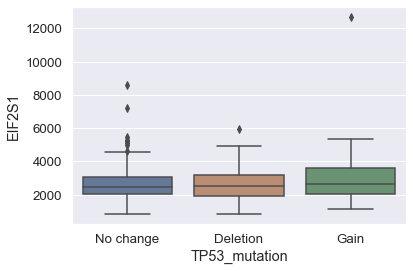

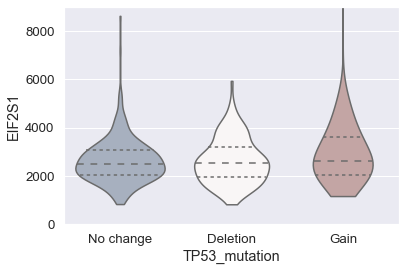

Results for EIF2S1 depending on the mutation of CDKN2A


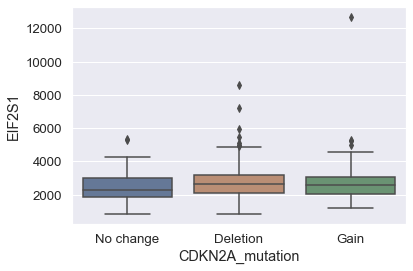

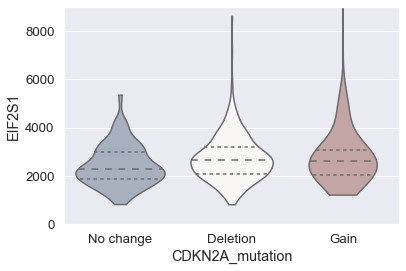

Results for EIF2S1 depending on the mutation of TGFBR2


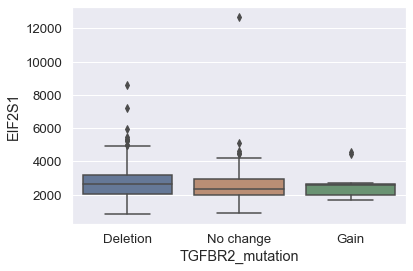

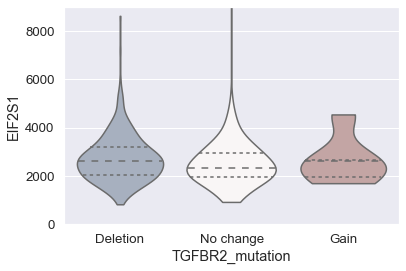

Results for EIF2S2 depending on the mutation of TP53


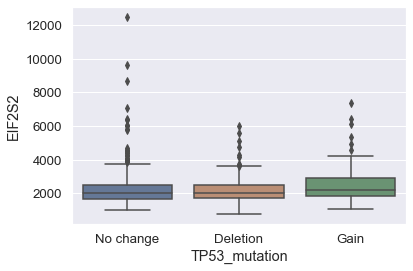

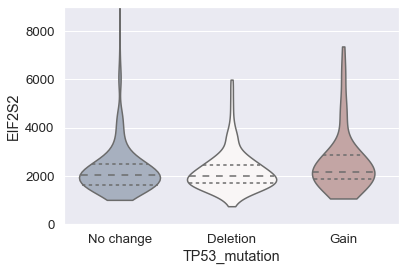

Results for EIF2S2 depending on the mutation of CDKN2A


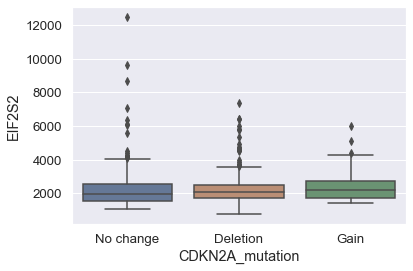

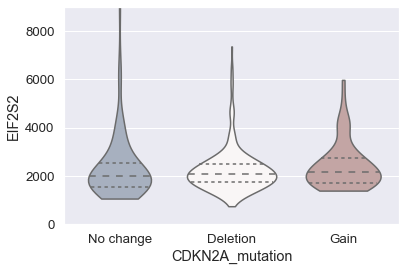

Results for EIF2S2 depending on the mutation of TGFBR2


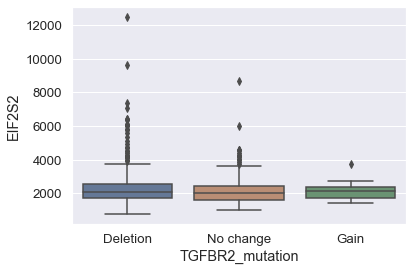

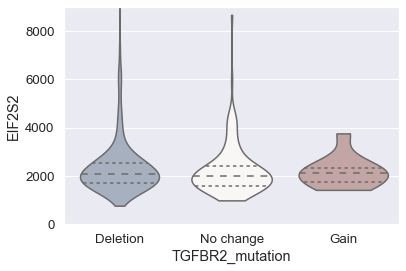

Results for EIF2S3 depending on the mutation of TP53


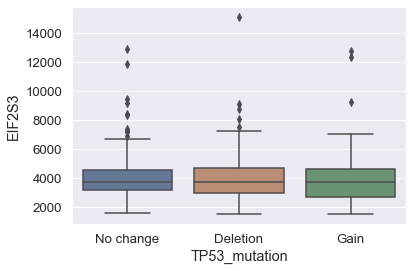

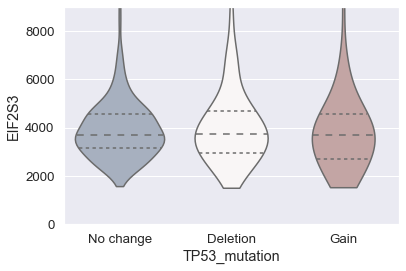

Results for EIF2S3 depending on the mutation of CDKN2A


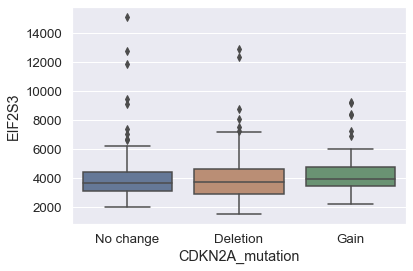

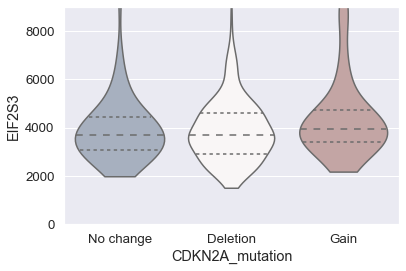

Results for EIF2S3 depending on the mutation of TGFBR2


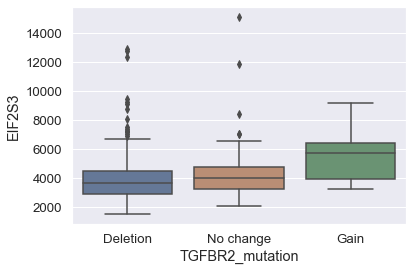

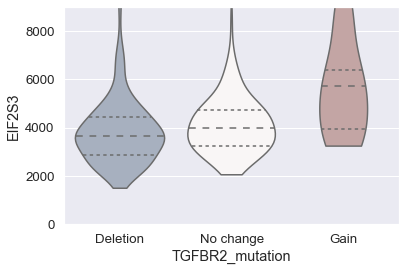

<IPython.core.display.Javascript object>

In [133]:
for mrna in mRNAs:
    for cna in CNAs:

        df_tmp = df[[mrna, cna]].copy()
        df_tmp.dropna(inplace=True)

        conditions = [
            df_tmp[cna] == 0,
            df_tmp[cna] * (df_tmp[cna] - 1) != 0,
            df_tmp[cna] == 1,
        ]
        choices = ["No change", "Deletion", "Gain"]
        new_column = f"{cna}_mutation"
        df_tmp[new_column] = np.select(conditions, choices)

        print(f"Results for {mrna} depending on the mutation of {cna}")

        # Box plot
        plt.figure()
        sns.set(font_scale=1.2)
        sns.boxplot(x=new_column, y=mrna, data=df_tmp, saturation=0.5)
        filename = f"boxplot_{mrna}_{col}.png"
        path_to_file = os.path.join(RESULTS_PATH, filename)
        plt.savefig(path_to_file)
        plt.show()

        # Violin plot
        plt.figure()
        sns.set(font_scale=1.2)
        sns.violinplot(
            x=new_column,
            y=mrna,
            data=df_tmp,
            scale="area",
            cut=0,
            saturation=0.5,
            inner="quartile",
            figsize=(15, 10),
            palette="vlag",
        )
        plt.ylim((0, 9000))
        filename = f"violinplot_{mrna}_{col}.png"
        path_to_file = os.path.join(RESULTS_PATH, filename)
        plt.savefig(path_to_file)
        plt.show()

## QQ-plots for mRNA expression depending on CNA mutation

Goal: compare the distributions of expression in two subgroups: with normal tissue and with mutated tissue.

Note: If the distributions are equal, they will lie on the diagonal. The more points deviate from the diagonal, the more diverse the distributions are.

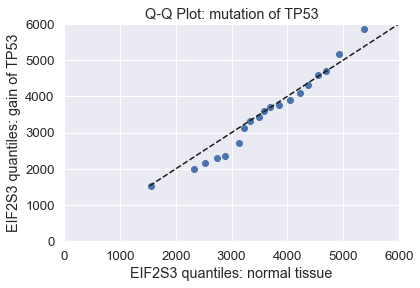

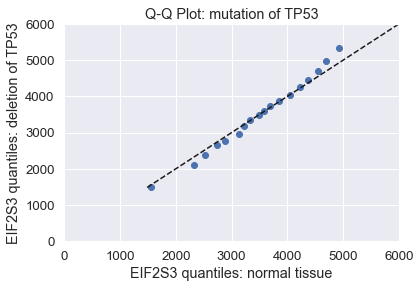

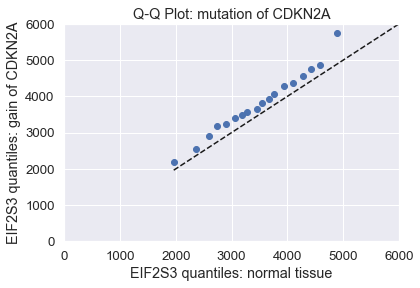

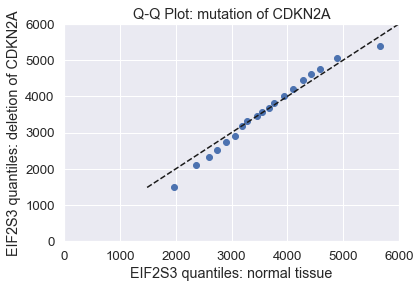

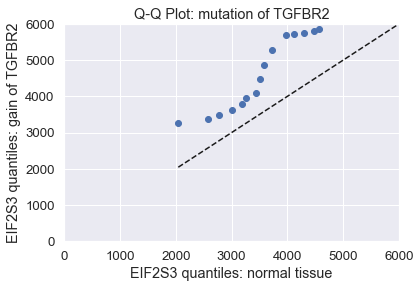

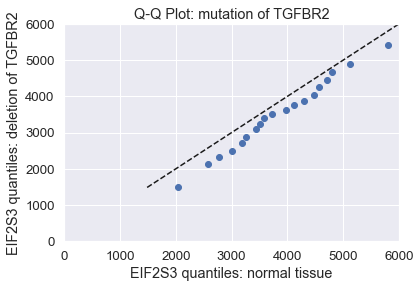

In [140]:
# for mrna in mRNAs:
    for cna in CNAs:

        percs = np.linspace(0, 100, 21)
        qn_a = np.percentile(normal_tissue[mrna][cna], percs)
        qn_b_1 = np.percentile(gain_tissue[mrna][cna], percs)
        qn_b_2 = np.percentile(deletion[mrna][cna], percs)

        # First plot gain
        plt.plot(qn_a, qn_b_1, ls="", marker="o")

        x = np.linspace(
            np.min((qn_a.min(), qn_b_1.min())), np.max((qn_a.max(), qn_b_1.max()))
        )
        sns.set(font_scale=1.2)
        plt.plot(x, x, color="k", ls="--")
        plt.axis([0, 6000, 0, 6000])
        plt.xlabel(f"{mrna} quantiles: normal tissue")
        plt.ylabel(f"{mrna} quantiles: gain of {cna}")
        plt.title(f"Q-Q Plot: mutation of {cna}")
        filename = f"QQPlot_{mrna}_{cna}_gain.png"
        path_to_file = os.path.join(RESULTS_PATH, filename)
        plt.savefig(path_to_file)
        plt.show()

        # Plot deletion mutation
        plt.plot(qn_a, qn_b_2, ls="", marker="o")

        x = np.linspace(
            np.min((qn_a.min(), qn_b_2.min())), np.max((qn_a.max(), qn_b_2.max()))
        )
        sns.set(font_scale=1.2)
        plt.plot(x, x, color="k", ls="--")
        plt.axis([0, 6000, 0, 6000])
        plt.xlabel(f"{mrna} quantiles: normal tissue")
        plt.ylabel(f"{mrna} quantiles: deletion of {cna}")
        plt.title(f"Q-Q Plot: mutation of {cna}")
        filename = f"QQPlot_{mrna}_{cna}_deletion.png"
        path_to_file = os.path.join(RESULTS_PATH, filename)
        plt.savefig(path_to_file)
        plt.show()